# 1. Introducere

## a. Prezentarea setului de date

√én cadrul acestui proiect, am ales sƒÉ lucrez cu setul de date **The Human Freedom Index**, oferit de **Cato Institute** »ôi **Fraser Institute**, disponibil pe platforma Kaggle. Acest set de date evalueazƒÉ »ôi comparƒÉ nivelul libertƒÉ»õii umane √Æn peste 160 de »õƒÉri, pe o perioadƒÉ extinsƒÉ de 21 de ani (2000‚Äì2020), »ôi reprezintƒÉ una dintre cele mai complete resurse globale privind libertƒÉ»õile personale »ôi economice.

Setul este structurat la nivel **anual**, iar fiecare r√¢nd corespunde unei »õƒÉri √Æntr-un anumit an. Sunt incluse peste **140 de variabile**, organizate √Æn jurul a trei dimensiuni principale:

- **LibertƒÉ»õi personale** ‚Äì exprimare, religie, identitate, libertatea de mi»ôcare, asocieri, siguran»õƒÉ personalƒÉ;
- **LibertƒÉ»õi economice** ‚Äì comer»õ interna»õional, reglementƒÉri guvernamentale, impozite, investi»õii;
- **Institu»õii legale** ‚Äì statul de drept, justi»õie proceduralƒÉ, integritate, libertƒÉ»õi constitu»õionale.

Printre cele mai relevante coloane regƒÉsim:
- `countries`, `region`, `year` ‚Äì pentru localizarea geograficƒÉ »ôi temporalƒÉ;
- `hf_score`, `hf_rank` ‚Äì scorul total al libertƒÉ»õii »ôi pozi»õia √Æn clasamentul global;
- numero»ôi sub-indicatori prefixa»õi cu `pf_` (personal freedom), `ef_` (economic freedom) »ôi `hf_` (human freedom), care oferƒÉ o granularitate ridicatƒÉ √Æn analiza libertƒÉ»õii.

Setul con»õine **3465 de √ÆnregistrƒÉri** »ôi **141 de coloane**, iar datele sunt √Æn mare parte numerice, dar con»õin »ôi variabile categorice. De asemenea, existƒÉ un procent semnificativ de **valori lipsƒÉ**, care vor necesita preprocesare atentƒÉ √Æn etapele ulterioare ale proiectului.

**Link cƒÉtre setul de date**: [https://www.kaggle.com/datasets/gsutters/the-human-freedom-index](https://www.kaggle.com/datasets/gsutters/the-human-freedom-index)

---

## b. Enun»õarea obiectivelor

Obiectivul general al acestui proiect este construirea unei aplica»õii de analizƒÉ Big Data care sƒÉ prelucreze, modeleze »ôi interpreteze date globale despre libertatea umanƒÉ. Proiectul √ÆmbinƒÉ componente de prelucrare distribuitƒÉ, Machine Learning, Deep Learning »ôi Streaming √Æn timp real ‚Äì pentru a arƒÉta cum pot fi extrase insight-uri relevante dintr-un set de date socio-politice complexe.

### Obiective specifice:
1. **Explorarea »ôi curƒÉ»õarea** datelor folosind PySpark »ôi Spark SQL;
2. **Analiza exploratorie** a distribu»õiei libertƒÉ»õilor √Æn func»õie de regiuni »ôi ani;
3. **Modelarea predictivƒÉ**: antrenarea unor algoritmi de Machine Learning pentru a prezice `hf_score` pe baza sub-indicatorilor (`pf_`, `ef_`);
4. **Construc»õia unui pipeline ML complet** cu Spark MLlib;
5. **Antrenarea unui model de Deep Learning** (cu TensorFlow) ca alternativƒÉ de predic»õie;
6. **Simularea unui flux de date √Æn timp real**, integrat cu predic»õia automatƒÉ, prin Spark Streaming »ôi un model ML salvat.

Prin aceste obiective, proiectul nu doar √Ændepline»ôte cerin»õele academice, ci demonstreazƒÉ »ôi aplicabilitatea tehnologiilor Big Data √Æn domeniul analizei sociale »ôi a politicilor publice.

# 2. Procesarea datelor cu Spark SQL »ôi DataFrames

## 2.1 CurƒÉ»õarea »ôi pregƒÉtirea ini»õialƒÉ a datelor

### Obiectiv

√én aceastƒÉ primƒÉ etapƒÉ de procesare, ne propunem sƒÉ transformƒÉm datele brute √Æntr-un format curat »ôi consistent, care sƒÉ poatƒÉ fi utilizat ulterior √Æn analize »ôi modele. Pentru aceasta, vom folosi func»õionalitƒÉ»õile oferite de PySpark, at√¢t prin API-ul DataFrame, c√¢t »ôi prin Spark SQL.

Mai exact, vom:
- elimina coloanele complet goale sau cu prea multe valori lipsƒÉ;
- converti tipurile de date relevante;
- pƒÉstra doar r√¢ndurile esen»õiale pentru analizƒÉ (`year`, `hf_score`, `countries`, `region`);
- verifica starea datasetului dupƒÉ curƒÉ»õare.

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import DoubleType, IntegerType

In [36]:
# 1. Ini»õializƒÉm SparkSession
spark = SparkSession.builder \
    .appName("HumanFreedomIndexProcessing") \
    .getOrCreate()

In [37]:
# 2. Citim setul de date
df = spark.read.csv("dataset/hfi_cc_2022.csv", header=True, inferSchema=True)
print(f"Dimensiune ini»õialƒÉ: {df.count()} r√¢nduri, {len(df.columns)} coloane")

Dimensiune ini»õialƒÉ: 3465 r√¢nduri, 141 coloane


In [38]:
# 3. EliminƒÉm coloanele complet nule
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_sums = null_counts.collect()[0].asDict()

In [39]:
cols_to_drop = [k for k, v in null_sums.items() if v == df.count()]
df_cleaned = df.drop(*cols_to_drop)
print(f"Eliminat {len(cols_to_drop)} coloane complet goale")

Eliminat 0 coloane complet goale


In [40]:
# 4. EliminƒÉm coloanele cu peste 50% valori lipsƒÉ
threshold = int(df.count() * 0.5)
cols_many_nulls = [k for k, v in null_sums.items() if v > threshold]
df_cleaned = df_cleaned.drop(*cols_many_nulls)
print(f"Eliminat {len(cols_many_nulls)} coloane cu peste 50% NaN")

Eliminat 5 coloane cu peste 50% NaN


In [41]:
# 5. Conversie tipuri
df_cleaned = df_cleaned.withColumn("year", col("year").cast(IntegerType()))
df_cleaned = df_cleaned.withColumn("hf_score", col("hf_score").cast(DoubleType()))
df_cleaned = df_cleaned.withColumn("hf_rank", col("hf_rank").cast(IntegerType()))

In [42]:
# 6. EliminƒÉm r√¢ndurile esen»õiale lipsƒÉ
essential_cols = ["year", "countries", "region", "hf_score"]
df_cleaned = df_cleaned.dropna(subset=essential_cols)

In [43]:
# 7. Schema »ôi dimensiune finalƒÉ
df_cleaned.printSchema()
print(f"Dimensiune finalƒÉ: {df_cleaned.count()} r√¢nduri, {len(df_cleaned.columns)} coloane")

root
 |-- year: integer (nullable = true)
 |-- countries: string (nullable = true)
 |-- region: string (nullable = true)
 |-- hf_score: double (nullable = true)
 |-- hf_rank: integer (nullable = true)
 |-- hf_quartile: double (nullable = true)
 |-- pf_rol_vdem: double (nullable = true)
 |-- pf_rol: double (nullable = true)
 |-- pf_ss_homicide: double (nullable = true)
 |-- pf_ss_homicide_data: double (nullable = true)
 |-- pf_ss_disappearances_disap: double (nullable = true)
 |-- pf_ss_disappearances_violent: double (nullable = true)
 |-- pf_ss_disappearances_violent_data: double (nullable = true)
 |-- pf_ss_disappearances_organized: double (nullable = true)
 |-- pf_ss_disappearances_fatalities: double (nullable = true)
 |-- pf_ss_disappearances_fatalities_data: double (nullable = true)
 |-- pf_ss_disappearances_injuries: double (nullable = true)
 |-- pf_ss_disappearances_injuries_data: double (nullable = true)
 |-- pf_ss_disappearances_torture: double (nullable = true)
 |-- pf_ss_kill

In [44]:
# 8. VerificƒÉm dacƒÉ mai sunt lipsuri
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show(n=1, truncate=False)

+----+---------+------+--------+-------+-----------+-----------+------+--------------+-------------------+--------------------------+----------------------------+---------------------------------+------------------------------+-------------------------------+------------------------------------+-----------------------------+----------------------------------+----------------------------+--------------+--------------------+-----+------------------------+--------------------+----------------------+----------------+---------------+-----------+------------------------+-----------------------+-------------------+-----------------------+-----------+-----------------+-------------------------+-----------------------+-----------------------+-------------------+----------------------------+------------------------+-------------------------+-------------------+-----------------+-----------+---------------------------+--------------------------------+---------------------------+------------------

In [45]:
# 9. SalvƒÉm ca view temporar pentru Spark SQL
df_cleaned.createOrReplaceTempView("freedom")

In [46]:
# 10. Extragere exemplu Rom√¢nia
spark.sql("SELECT * FROM freedom WHERE countries = 'Romania'").show(truncate=False)

+----+---------+--------------+--------+-------+-----------+-----------------+-----------------+-----------------+-------------------+--------------------------+----------------------------+---------------------------------+------------------------------+-------------------------------+------------------------------------+-----------------------------+----------------------------------+----------------------------+--------------+--------------------+-----------------+------------------------+--------------------+----------------------+-----------------+-----------------+-----------------+------------------------+-----------------------+-------------------+-----------------------+-----------------+-----------------+-------------------------+-----------------------+-----------------------+-------------------+----------------------------+------------------------+-------------------------+-------------------+-----------------+-----------------+---------------------------+------------------

### Concluzii

Am curƒÉ»õat semnificativ setul de date, pƒÉstr√¢nd doar coloanele relevante »ôi elimin√¢nd valorile lipsƒÉ critice. Datasetul rezultat este mult mai u»ôor de analizat »ôi interpretat, at√¢t din punct de vedere statistic, c√¢t »ôi computa»õional.

√én sec»õiunea urmƒÉtoare, vom realiza **agregƒÉri »ôi grupƒÉri** pentru a explora cum evolueazƒÉ libertatea √Æn diferite regiuni ale lumii.

## 2.2 Analize exploratorii: grupƒÉri »ôi agregƒÉri relevante

### Obiectiv general

√én aceastƒÉ sec»õiune vom realiza mai multe **agregƒÉri »ôi grupƒÉri semnificative** asupra setului de date, cu scopul de a eviden»õia:

- care sunt cele mai libere »õƒÉri din lume (pe medie);
- care »õƒÉri au √Ænregistrat cele mai mari progrese sau regrese √Æn libertate;
- cum evolueazƒÉ libertatea √Æn func»õie de regiune »ôi timp;
- rela»õia dintre libertatea personalƒÉ »ôi cea economicƒÉ;
- »õƒÉrile unde existƒÉ un dezechilibru major √Æntre dimensiunile de libertate;
- clasificarea »õƒÉrilor √Æn categorii proprii de libertate: √ÆnaltƒÉ, medie »ôi scƒÉzutƒÉ.

Pentru fiecare analizƒÉ vom utiliza **PySpark DataFrame API** »ôi **Spark SQL**, iar √Æn unele cazuri vom include vizualizƒÉri pentru a sprijini interpretarea rezultatelor.

### 2.2.1 Top 10 »õƒÉri cu cele mai mari scoruri de libertate (medie)

**Obiectiv**: SƒÉ identificƒÉm cele mai libere »õƒÉri din lume pe baza scorului hf_score, calculat ca medie pe toate √ÆnregistrƒÉrile disponibile pentru fiecare »õarƒÉ √Æn perioada analizatƒÉ.

AceastƒÉ analizƒÉ ne va ajuta sƒÉ √Æn»õelegem care state men»õin constant un nivel ridicat de libertate umanƒÉ, indiferent de contextul global sau regional.

Vom realiza agregarea at√¢t cu PySpark DataFrame API, c√¢t »ôi cu Spark SQL, pentru a valida rezultatele »ôi a demonstra versatilitatea platformei Spark. Rezultatul va fi prezentat at√¢t tabelar, c√¢t »ôi vizual.

In [47]:
# 1. Cream o vizualizare temporarƒÉ pentru Spark SQL
df_cleaned.createOrReplaceTempView("freedom_data")

In [48]:
# 2. Top 10 »õƒÉri cu cele mai mari scoruri medii - cu PySpark DataFrame API
from pyspark.sql.functions import avg

top10_df = df_cleaned.groupBy("countries") \
    .agg(avg("hf_score").alias("avg_hf_score")) \
    .orderBy(col("avg_hf_score").desc()) \
    .limit(10)

top10_df.show(truncate=False)

+--------------+-----------------+
|countries     |avg_hf_score     |
+--------------+-----------------+
|Switzerland   |9.166666666666666|
|New Zealand   |9.09             |
|Denmark       |8.995714285714287|
|Finland       |8.915238095238097|
|Australia     |8.907619047619047|
|United Kingdom|8.904285714285715|
|Ireland       |8.899047619047618|
|Sweden        |8.88095238095238 |
|Canada        |8.855714285714285|
|United States |8.827142857142857|
+--------------+-----------------+



In [49]:
# 3. Top 10 cu Spark SQL
query = """
SELECT countries, ROUND(AVG(hf_score), 2) AS avg_hf_score
FROM freedom_data
GROUP BY countries
ORDER BY avg_hf_score DESC
LIMIT 10
"""

In [50]:
top10_sql = spark.sql(query)
top10_sql.show(truncate=False)

+--------------+------------+
|countries     |avg_hf_score|
+--------------+------------+
|Switzerland   |9.17        |
|New Zealand   |9.09        |
|Denmark       |9.0         |
|Finland       |8.92        |
|Australia     |8.91        |
|Ireland       |8.9         |
|United Kingdom|8.9         |
|Sweden        |8.88        |
|Canada        |8.86        |
|United States |8.83        |
+--------------+------------+



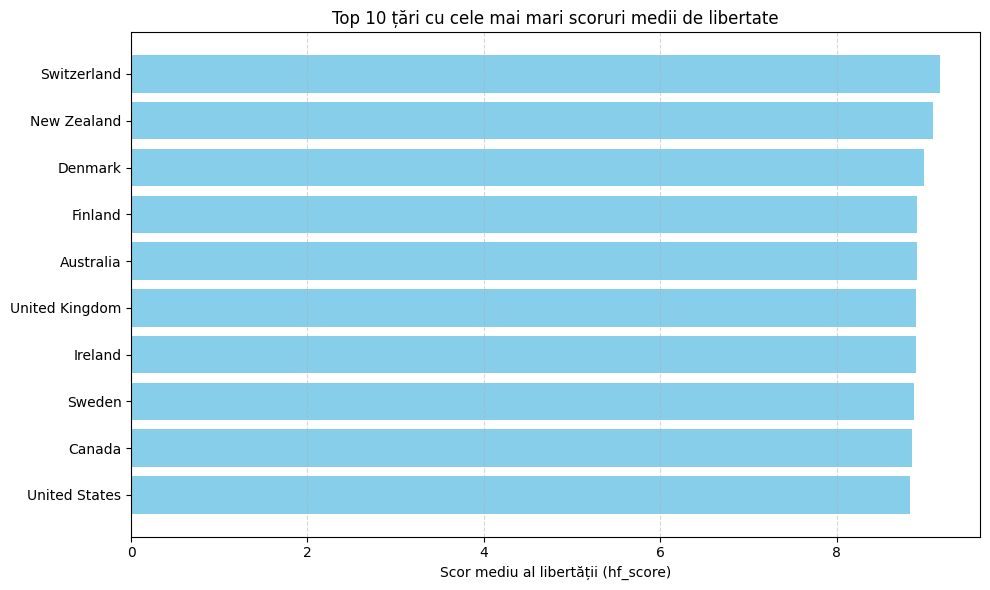

In [51]:
# 4. Vizualizare (cu Matplotlib)
import matplotlib.pyplot as plt

# Convertim rezultatul la Pandas DataFrame
top10_pd = top10_df.toPandas()

# Plot ‚Äì barƒÉ orizontalƒÉ
plt.figure(figsize=(10, 6))
plt.barh(top10_pd['countries'][::-1], top10_pd['avg_hf_score'][::-1], color='skyblue')
plt.xlabel('Scor mediu al libertƒÉ»õii (hf_score)')
plt.title('Top 10 »õƒÉri cu cele mai mari scoruri medii de libertate')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2.2 Evolu»õia libertƒÉ»õii √Æn 20 de ani: »õƒÉrile cu cele mai mari cre»ôteri »ôi scƒÉderi (2000 vs. 2020)

**Obiectiv**: SƒÉ identificƒÉm »õƒÉrile care au √Ænregistrat cele mai semnificative progrese sau regrese √Æn privin»õa libertƒÉ»õii umane, compar√¢nd scorurile hf_score din anii 2000 »ôi 2020.

Vom calcula diferen»õa dintre scorurile de libertate pentru fiecare »õarƒÉ prezentƒÉ √Æn ambii ani, extrƒÉg√¢nd:

- Top 10 »õƒÉri cu cea mai mare cre»ôtere a scorului de libertate;

- Top 10 »õƒÉri cu cea mai mare scƒÉdere a acestui scor.

AceastƒÉ analizƒÉ oferƒÉ o perspectivƒÉ clarƒÉ asupra modului √Æn care evolu»õiile geopolitice »ôi economice au influen»õat nivelul libertƒÉ»õii √Æn ultimele douƒÉ decenii.


In [52]:
from pyspark.sql.functions import col

In [53]:
# 1. FiltrƒÉm doar anii 2000 »ôi 2020 »ôi eliminƒÉm valorile lipsƒÉ
df_2000 = df_cleaned.filter(col("year") == 2000) \
    .select("countries", "hf_score") \
    .dropna(subset=["hf_score"]) \
    .withColumnRenamed("hf_score", "hf_score_2000")

df_2020 = df_cleaned.filter(col("year") == 2020) \
    .select("countries", "hf_score") \
    .dropna(subset=["hf_score"]) \
    .withColumnRenamed("hf_score", "hf_score_2020")

In [54]:
# 2. AlƒÉturƒÉm cele douƒÉ DataFrame-uri dupƒÉ "countries"
df_diff = df_2000.join(df_2020, on="countries", how="inner")

In [55]:
# 3. CalculƒÉm diferen»õa scorurilor
df_diff = df_diff.withColumn("score_change", col("hf_score_2020") - col("hf_score_2000"))

In [56]:
# 4. Top 10 cre»ôteri
top10_up = df_diff.orderBy(col("score_change").desc()).limit(10)
print("Top 10 cre»ôteri √Æntre 2000 »ôi 2020:")
top10_up.show(truncate=False)

Top 10 cre»ôteri √Æntre 2000 »ôi 2020:
+----------------+-------------+-------------+------------------+
|countries       |hf_score_2000|hf_score_2020|score_change      |
+----------------+-------------+-------------+------------------+
|Myanmar         |3.64         |5.56         |1.9199999999999995|
|Sierra Leone    |5.26         |6.53         |1.2700000000000005|
|Tunisia         |5.27         |6.25         |0.9800000000000004|
|Guinea-Bissau   |5.56         |6.54         |0.9800000000000004|
|Cyprus          |7.32         |8.13         |0.8100000000000005|
|Congo, Dem. Rep.|4.64         |5.39         |0.75              |
|Romania         |7.2          |7.89         |0.6899999999999995|
|Colombia        |5.97         |6.65         |0.6800000000000006|
|Nepal           |6.12         |6.77         |0.6499999999999995|
|Togo            |5.61         |6.25         |0.6399999999999997|
+----------------+-------------+-------------+------------------+



In [57]:
# 5. Top 10 scƒÉderi
top10_down = df_diff.orderBy(col("score_change").asc()).limit(10)
print("Top 10 scƒÉderi √Æntre 2000 »ôi 2020:")
top10_down.show(truncate=False)

Top 10 scƒÉderi √Æntre 2000 »ôi 2020:
+--------------------+-------------+-------------+-------------------+
|countries           |hf_score_2000|hf_score_2020|score_change       |
+--------------------+-------------+-------------+-------------------+
|Venezuela, RB       |6.43         |4.09         |-2.34              |
|Nicaragua           |7.34         |5.96         |-1.38              |
|Egypt, Arab Rep.    |5.49         |4.28         |-1.21              |
|Syrian Arab Republic|4.47         |3.3          |-1.17              |
|Bolivia             |7.73         |6.6          |-1.1300000000000008|
|El Salvador         |7.74         |6.65         |-1.0899999999999999|
|Argentina           |8.06         |6.99         |-1.0700000000000003|
|Iran, Islamic Rep.  |5.14         |4.26         |-0.8799999999999999|
|Hong Kong SAR, China|8.87         |8.01         |-0.8599999999999994|
|Thailand            |7.35         |6.49         |-0.8599999999999994|
+--------------------+-------------+---

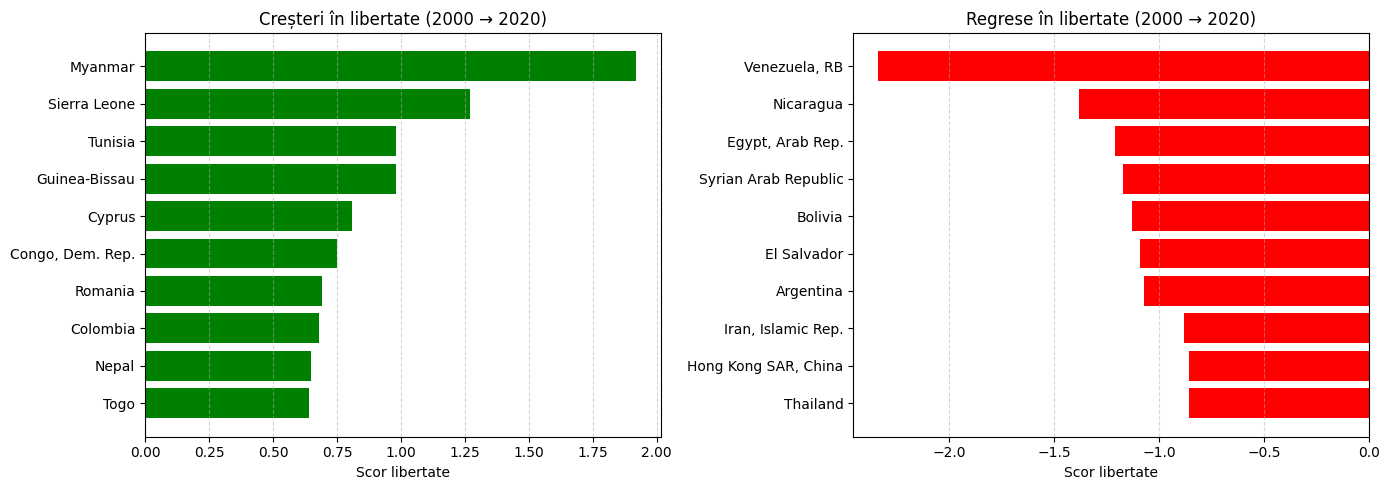

In [59]:
# 6. Vizualizare comparativƒÉ
import matplotlib.pyplot as plt

top_up_pd = top10_up.toPandas()
top_down_pd = top10_down.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cre»ôteri
axes[0].barh(top_up_pd['countries'][::-1], top_up_pd['score_change'][::-1], color='green')
axes[0].set_title('Cre»ôteri √Æn libertate (2000 ‚Üí 2020)')
axes[0].set_xlabel('Scor libertate')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# ScƒÉderi
axes[1].barh(top_down_pd['countries'][::-1], top_down_pd['score_change'][::-1], color='red')
axes[1].set_title('Regrese √Æn libertate (2000 ‚Üí 2020)')
axes[1].set_xlabel('Scor libertate')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.2.3 Evolu»õia mediei scorului `hf_score` pe regiuni √Æntre 2000 »ôi 2020

**Obiectiv**: sƒÉ analizƒÉm dinamica libertƒÉ»õii umane √Æn timp, pe regiuni geografice, prin evolu»õia scorului mediu hf_score √Æn perioada 2000‚Äì2020.

AceastƒÉ analizƒÉ eviden»õiazƒÉ:

- Regiunile cu √ÆmbunƒÉtƒÉ»õiri consistente √Æn libertate;

- Regiunile √Æn care nivelul de libertate a scƒÉzut sau a stagnat;

- Compara»õii regionale anuale pentru decizii de politicƒÉ »ôi cercetare.

Vizualizarea sub formƒÉ de line chart ajutƒÉ la √Æn»õelegerea clarƒÉ a tendin»õelor globale »ôi regionale.

In [60]:
from pyspark.sql.functions import avg, col

In [61]:
# 1. FiltrƒÉm perioada doritƒÉ
df_range = df_cleaned.filter((col("year") >= 2000) & (col("year") <= 2020))

In [62]:
# 2. GrupƒÉm dupƒÉ regiune »ôi an, calcul√¢nd media scorului
df_region_year = df_range.groupBy("region", "year") \
    .agg(avg("hf_score").alias("avg_hf_score")) \
    .orderBy("region", "year")

df_region_year.show(10, truncate=False)

+-----------------------+----+------------------+
|region                 |year|avg_hf_score      |
+-----------------------+----+------------------+
|Caucasus & Central Asia|2000|7.15              |
|Caucasus & Central Asia|2003|7.39              |
|Caucasus & Central Asia|2004|7.116666666666667 |
|Caucasus & Central Asia|2005|6.87              |
|Caucasus & Central Asia|2006|6.8340000000000005|
|Caucasus & Central Asia|2007|6.814             |
|Caucasus & Central Asia|2008|6.746             |
|Caucasus & Central Asia|2009|6.628             |
|Caucasus & Central Asia|2010|6.535             |
|Caucasus & Central Asia|2011|6.538333333333334 |
+-----------------------+----+------------------+
only showing top 10 rows


In [63]:
# 3. Conversie la Pandas pentru vizualizare
df_plot = df_region_year.toPandas()

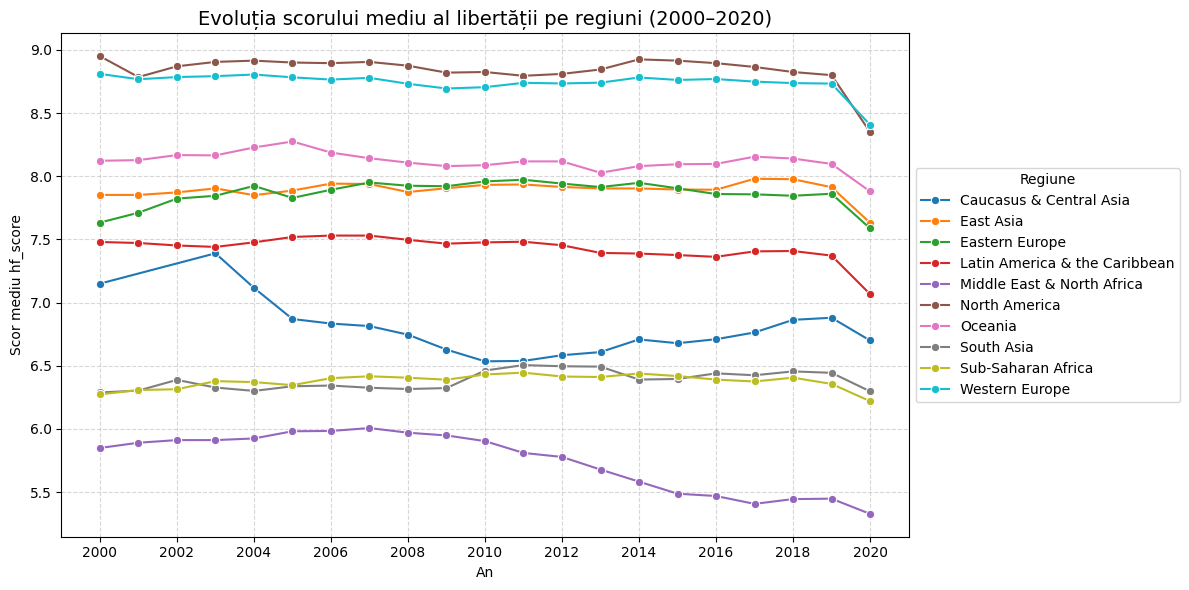

In [64]:
# 4. Vizualizare cu seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_plot,
    x="year",
    y="avg_hf_score",
    hue="region",
    marker="o"
)

plt.title("Evolu»õia scorului mediu al libertƒÉ»õii pe regiuni (2000‚Äì2020)", fontsize=14)
plt.xlabel("An")
plt.ylabel("Scor mediu hf_score")
plt.xticks(range(2000, 2021, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Regiune", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### 2.2.4 Rela»õia dintre libertatea personalƒÉ »ôi libertatea economicƒÉ

**Obiectiv**: sƒÉ analizƒÉm rela»õia dintre pf_score (libertate personalƒÉ) »ôi ef_score (libertate economicƒÉ), pentru a √Æn»õelege dacƒÉ existƒÉ o corela»õie directƒÉ √Æntre cele douƒÉ dimensiuni ale libertƒÉ»õii. Ne √ÆntrebƒÉm: »õƒÉrile care oferƒÉ mai multƒÉ libertate personalƒÉ oferƒÉ automat »ôi mai multƒÉ libertate economicƒÉ?

Pentru aceasta, vom:

- folosi un scatter plot colorat √Æn func»õie de regiune;

- calcula coeficientul de corela»õie Pearson pentru a mƒÉsura intensitatea »ôi direc»õia legƒÉturii;

- compara rela»õia folosind toate √ÆnregistrƒÉrile anuale versus scoruri medii pe »õarƒÉ.

In [65]:
# 1. SelectƒÉm scorurile necesare »ôi eliminƒÉm valorile lipsƒÉ
df_pair = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"])

In [66]:
# 2. Conversie la Pandas pentru vizualizare
df_pair_pd = df_pair.toPandas()

In [67]:
df_pair_pd

countries                         region  year  pf_score  ef_score
0           Albania                 Eastern Europe  2020      7.69      7.64
1           Algeria     Middle East & North Africa  2020      5.13      5.12
2            Angola             Sub-Saharan Africa  2020      6.02      5.91
3         Argentina  Latin America & the Caribbean  2020      8.51      4.87
4           Armenia        Caucasus & Central Asia  2020      8.35      7.84
...             ...                            ...   ...       ...       ...
3078        Uruguay  Latin America & the Caribbean  2000      9.04      7.14
3079  Venezuela, RB  Latin America & the Caribbean  2000      6.79      5.92
3080        Vietnam                     South Asia  2000      5.48      5.58
3081         Zambia             Sub-Saharan Africa  2000      7.03      7.04
3082       Zimbabwe             Sub-Saharan Africa  2000      5.94      4.53

[3083 rows x 5 columns]

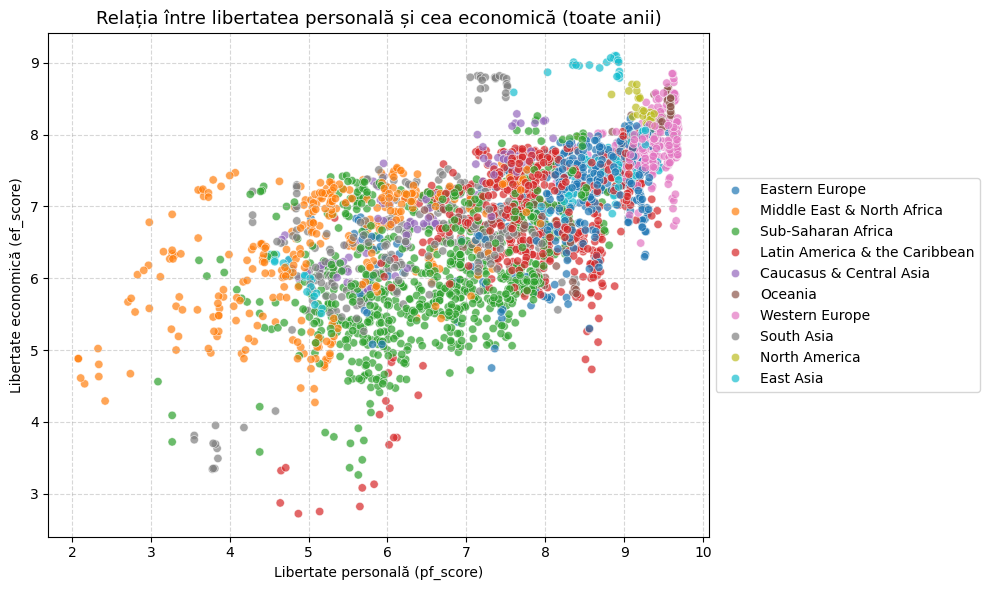

In [68]:
# 3. Vizualizare: scatter plot complet
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_pair_pd,
    x="pf_score",
    y="ef_score",
    hue="region",
    alpha=0.7
)

plt.title("Rela»õia √Æntre libertatea personalƒÉ »ôi cea economicƒÉ (toate anii)", fontsize=13)
plt.xlabel("Libertate personalƒÉ (pf_score)")
plt.ylabel("Libertate economicƒÉ (ef_score)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [69]:
# 4. Corela»õie Pearson + Statistici descriptive
corr_value = df_pair_pd["pf_score"].corr(df_pair_pd["ef_score"])
print(f"Coeficient de corela»õie Pearson: {corr_value:.4f}")

print("\nStatistici descriptive:")
print(df_pair_pd[["pf_score", "ef_score"]].describe())

Coeficient de corela»õie Pearson: 0.6600

Statistici descriptive:
          pf_score     ef_score
count  3083.000000  3083.000000
mean      7.373876     6.806610
std       1.577346     0.991279
min       2.080000     2.720000
25%       6.120000     6.130000
50%       7.570000     6.930000
75%       8.700000     7.580000
max       9.690000     9.100000


Observa»õie:

Analiza anterioarƒÉ a inclus toate √ÆnregistrƒÉrile anuale pentru fiecare »õarƒÉ, ceea ce oferƒÉ o imagine detaliatƒÉ, dar zgomotoasƒÉ.  
Pentru a √Æn»õelege rela»õia structuralƒÉ √Æntre cele douƒÉ dimensiuni, vom recomputa scorurile **medii pe »õarƒÉ** pentru perioada 2000‚Äì2020 »ôi vom analiza corela»õia la acest nivel.

In [70]:
# 5. Calcul scoruri medii pe »õƒÉri »ôi regiuni
df_avg_scores = df_cleaned.groupBy("countries", "region") \
    .agg({"pf_score": "avg", "ef_score": "avg"}) \
    .withColumnRenamed("avg(pf_score)", "avg_pf_score") \
    .withColumnRenamed("avg(ef_score)", "avg_ef_score")

df_avg_scores_pd = df_avg_scores.toPandas()

In [75]:
import pandas as pd

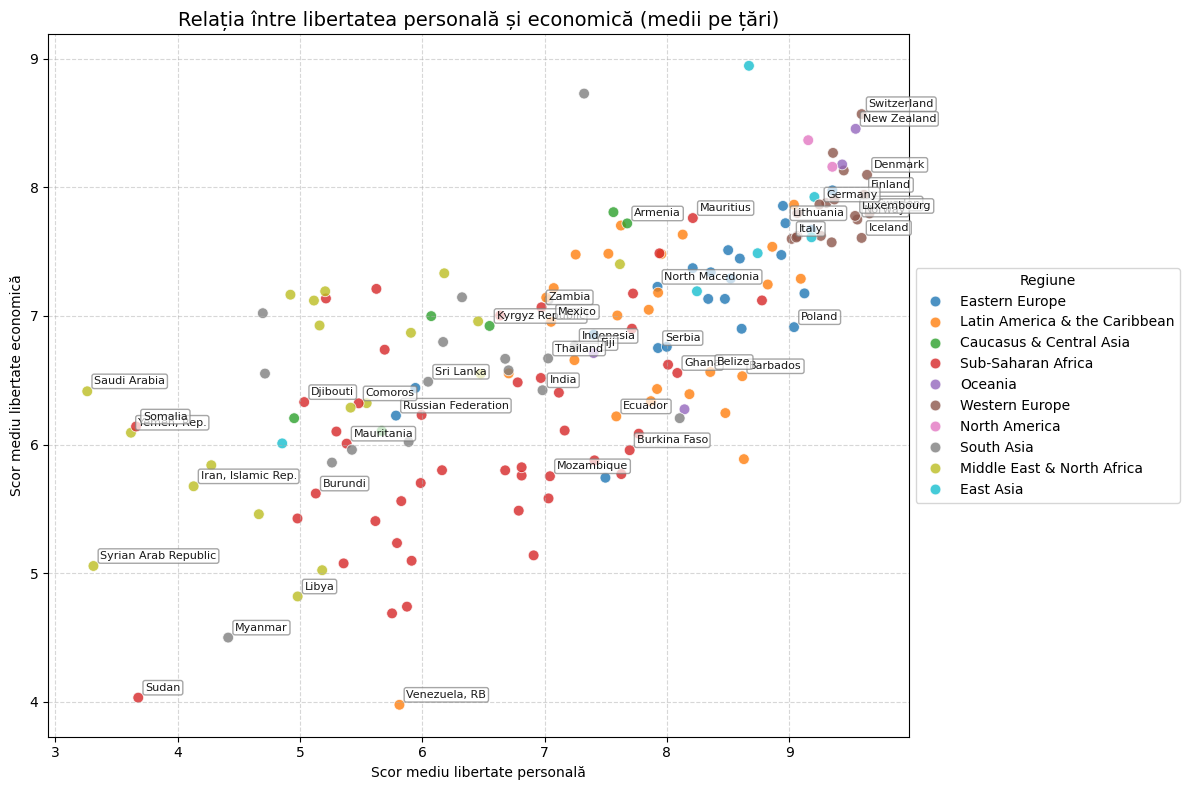

In [81]:
# 6. Scatter plot cu numele unor »õƒÉri afi»ôate
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_avg_scores_pd,
    x="avg_pf_score",
    y="avg_ef_score",
    hue="region",
    alpha=0.8,
    s=60
)

# AdƒÉugƒÉm etichete pentru »õƒÉrile extreme (wings)
# IdentificƒÉm »õƒÉrile cu scoruri foarte mari sau foarte mici
extreme_countries = df_avg_scores_pd[
    (df_avg_scores_pd["avg_pf_score"] >= 9.5) |  # Libertate personalƒÉ foarte mare
    (df_avg_scores_pd["avg_pf_score"] <= 4.0) |  # Libertate personalƒÉ foarte micƒÉ
    (df_avg_scores_pd["avg_ef_score"] >= 9) |  # Libertate economicƒÉ foarte mare
    (df_avg_scores_pd["avg_ef_score"] <= 4.5) |  # Libertate economicƒÉ foarte micƒÉ
    (df_avg_scores_pd["avg_pf_score"] + df_avg_scores_pd["avg_ef_score"] >= 18.0) |  # Scoruri totale foarte mari
    (df_avg_scores_pd["avg_pf_score"] + df_avg_scores_pd["avg_ef_score"] <= 10.0)    # Scoruri totale foarte mici
]

# AdƒÉugƒÉm »ôi c√¢teva »õƒÉri aleatorii pentru context
random_countries = df_avg_scores_pd.sample(30, random_state=42)
countries_to_label = pd.concat([extreme_countries, random_countries]).drop_duplicates()

# AdƒÉugƒÉm etichetele
for idx, row in countries_to_label.iterrows():
    plt.annotate(
        row["countries"],
        (row["avg_pf_score"], row["avg_ef_score"]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="gray")
    )

plt.title("Rela»õia √Æntre libertatea personalƒÉ »ôi economicƒÉ (medii pe »õƒÉri)", fontsize=14)
plt.xlabel("Scor mediu libertate personalƒÉ")
plt.ylabel("Scor mediu libertate economicƒÉ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Regiune", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [83]:
# 7. Corela»õie finalƒÉ
corr_avg = df_avg_scores_pd["avg_pf_score"].corr(df_avg_scores_pd["avg_ef_score"])
print(f"Coeficient Pearson (medii pe »õƒÉri): {corr_avg:.4f}")

Coeficient Pearson (medii pe »õƒÉri): 0.6940


### 2.2.5 Dezechilibrul √Æntre libertatea economicƒÉ »ôi cea personalƒÉ (`freedom_gap`)

**Obiectiv**: sƒÉ identificƒÉm »õƒÉrile √Æn care existƒÉ un dezechilibru semnificativ √Æntre libertatea economicƒÉ (ef_score) »ôi libertatea personalƒÉ (pf_score), prin introducerea unei noi coloane calculate:
freedom_gap = pf_score - ef_score

- Valori pozitive ‚Üí »õƒÉri unde libertatea personalƒÉ este mai mare dec√¢t cea economicƒÉ
- Valori negative ‚Üí »õƒÉri unde libertatea economicƒÉ este mai mare dec√¢t cea personalƒÉ

AceastƒÉ analizƒÉ oferƒÉ o perspectivƒÉ ineditƒÉ asupra diferen»õelor structurale √Æntre societƒÉ»õi, sco»õ√¢nd √Æn eviden»õƒÉ »õƒÉri cu politici dezechilibrate sau contradictorii √Æntre dimensiunile libertƒÉ»õii.

Vom realiza:

- o analizƒÉ descriptivƒÉ cu Spark »ôi Spark SQL;

- douƒÉ clasamente: top 10 »õƒÉri cu cel mai mare exces de libertate personalƒÉ »ôi top 10 cu exces economic;

- o vizualizare de tip bar chart pentru cele mai dezechilibrate 30 de »õƒÉri.

In [84]:
from pyspark.sql.functions import round, col
import matplotlib.pyplot as plt
import pandas as pd

In [85]:
# 1. CalculƒÉm diferen»õa: pf_score - ef_score
df_gap = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"]) \
    .withColumn("freedom_gap", round(col("pf_score") - col("ef_score"), 2))

In [86]:
# 2. CalculƒÉm media gap-ului pe »õƒÉri »ôi regiuni
df_gap_avg = df_gap.groupBy("countries", "region") \
    .agg({"freedom_gap": "avg"}) \
    .withColumnRenamed("avg(freedom_gap)", "avg_freedom_gap") \
    .orderBy(col("avg_freedom_gap").desc())

In [46]:
# 1. Calculam diferenta intre scorurile de libertate personala si economica
df_gap = df_cleaned.select("countries", "region", "year", "pf_score", "ef_score") \
    .dropna(subset=["pf_score", "ef_score"]) \
    .withColumn("freedom_gap", round(col("pf_score") - col("ef_score"), 2))

In [87]:
# 3. CreƒÉm view pentru interogƒÉri SQL
df_gap_avg.createOrReplaceTempView("gap_scores")

In [88]:
# 4. Top 10 »õƒÉri cu libertate personalƒÉ > economicƒÉ
print("Top 10 »õƒÉri: libertate personalƒÉ mai mare")
spark.sql("""
SELECT countries, region, ROUND(avg_freedom_gap, 2) as gap
FROM gap_scores
WHERE avg_freedom_gap > 0
ORDER BY gap DESC
LIMIT 10
""").show()

Top 10 »õƒÉri: libertate personalƒÉ mai mare
+----------------+--------------------+----+
|       countries|              region| gap|
+----------------+--------------------+----+
|       Argentina|Latin America & t...|2.74|
|        Suriname|Latin America & t...|2.23|
|          Poland|      Eastern Europe|2.13|
|        Barbados|Latin America & t...|2.09|
|         Iceland|      Western Europe|1.99|
|        Slovenia|      Eastern Europe|1.95|
|     Timor-Leste|          South Asia| 1.9|
|Papua New Guinea|             Oceania|1.87|
|          Sweden|      Western Europe|1.86|
|          Malawi|  Sub-Saharan Africa|1.86|
+----------------+--------------------+----+



In [89]:
# 5. Top 10 »õƒÉri cu libertate economicƒÉ > personalƒÉ
print("Top 10 »õƒÉri: libertate economicƒÉ mai mare")
spark.sql("""
SELECT countries, region, ROUND(avg_freedom_gap, 2) as gap
FROM gap_scores
WHERE avg_freedom_gap < 0
ORDER BY gap ASC
LIMIT 10
""").show()

Top 10 »õƒÉri: libertate economicƒÉ mai mare
+--------------------+--------------------+-----+
|           countries|              region|  gap|
+--------------------+--------------------+-----+
|        Saudi Arabia|Middle East & Nor...|-3.15|
|             Somalia|  Sub-Saharan Africa|-2.48|
|         Yemen, Rep.|Middle East & Nor...|-2.47|
|   Brunei Darussalam|          South Asia|-2.32|
|             Bahrain|Middle East & Nor...|-2.24|
|               Qatar|Middle East & Nor...| -2.0|
|United Arab Emirates|Middle East & Nor...|-1.98|
|         Gambia, The|  Sub-Saharan Africa|-1.92|
|             Lao PDR|          South Asia|-1.84|
|                Oman|Middle East & Nor...|-1.76|
+--------------------+--------------------+-----+



In [90]:
# 6. PregƒÉtim vizualizarea cu cele mai dezechilibrate cazuri
df_gap_plot = df_gap_avg.toPandas()

In [91]:
# SelectƒÉm cele mai dezechilibrate 30 de »õƒÉri (15 pozitive, 15 negative)
top_positive = df_gap_plot.nlargest(15, 'avg_freedom_gap')
top_negative = df_gap_plot.nsmallest(15, 'avg_freedom_gap')
extreme_gaps = pd.concat([top_positive, top_negative]).sort_values("avg_freedom_gap", ascending=False)

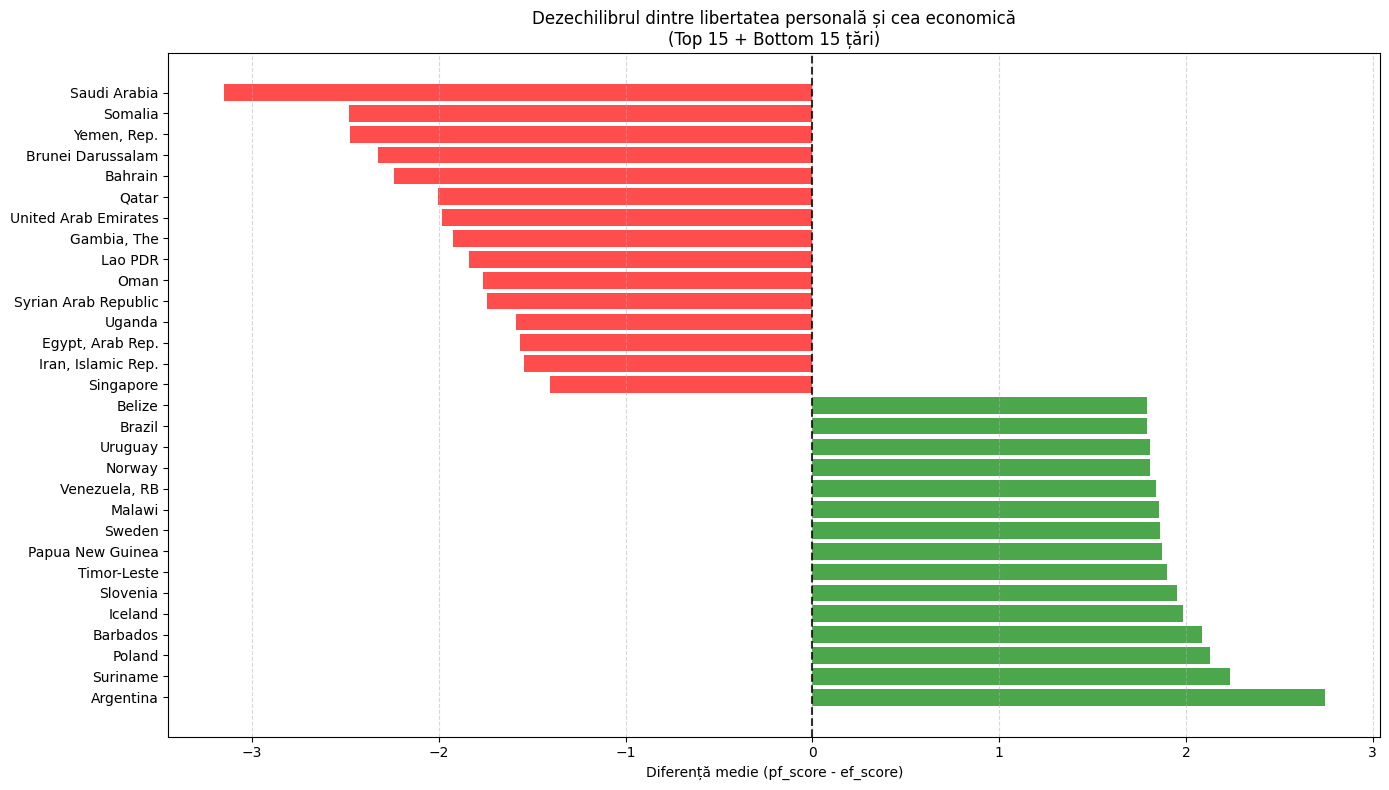

In [92]:
# 7. Bar chart cu colorare √Æn func»õie de semn
plt.figure(figsize=(14, 8))
colors = ['green' if x > 0 else 'red' for x in extreme_gaps['avg_freedom_gap']]
plt.barh(range(len(extreme_gaps)), extreme_gaps['avg_freedom_gap'], color=colors, alpha=0.7)
plt.yticks(range(len(extreme_gaps)), extreme_gaps['countries'])
plt.title("Dezechilibrul dintre libertatea personalƒÉ »ôi cea economicƒÉ\n(Top 15 + Bottom 15 »õƒÉri)")
plt.xlabel("Diferen»õƒÉ medie (pf_score - ef_score)")
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2.2.6 »öƒÉrile cu cel mai scƒÉzut nivel al libertƒÉ»õii de exprimare

### Descriere »ôi obiectiv

√én aceastƒÉ analizƒÉ dorim sƒÉ identificƒÉm »õƒÉrile cu cel mai scƒÉzut nivel al libertƒÉ»õii de exprimare √Æn perioada 2000‚Äì2020, folosind indicatorul pf_expression_direct.

Acest scor reflectƒÉ nivelul de represiune exercitat de autoritƒÉ»õi asupra jurnali»ôtilor, activi»ôtilor »ôi cetƒÉ»õenilor, incluz√¢nd:

- arestƒÉri politice;

- amenin»õƒÉri »ôi intimidƒÉri sistematice;

- acte de violen»õƒÉ √Æmpotriva libertƒÉ»õii de opinie.

Prin calculul mediei pe 20 de ani, ob»õinem o imagine de ansamblu stabilƒÉ asupra climatului represiv din diferite »õƒÉri.

Vor fi prezentate:

- Top 10 »õƒÉri cu cel mai scƒÉzut scor mediu la pf_expression_direct;

- o vizualizare de tip bar chart, cu segmentare pe regiuni.

In [93]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# 1. SelectƒÉm coloanele relevante »ôi eliminƒÉm valorile lipsƒÉ
df_expr = df_cleaned.select("countries", "year", "region", "pf_expression_direct") \
    .dropna(subset=["pf_expression_direct"])

In [96]:
# 2. CreƒÉm view temporar pentru interogare SQL
df_expr.createOrReplaceTempView("expr_view")

In [97]:
# 3. CalculƒÉm media scorului √Æntre 2000 »ôi 2020 pentru fiecare »õarƒÉ
expr_avg_df = spark.sql("""
    SELECT countries, region, ROUND(AVG(pf_expression_direct), 2) AS avg_expression_score
    FROM expr_view
    WHERE year BETWEEN 2000 AND 2020
    GROUP BY countries, region
    ORDER BY avg_expression_score ASC
    LIMIT 10
""")

expr_avg_df.show(truncate=False)

+--------------------+--------------------------+--------------------+
|countries           |region                    |avg_expression_score|
+--------------------+--------------------------+--------------------+
|Somalia             |Sub-Saharan Africa        |1.67                |
|Israel              |Middle East & North Africa|2.32                |
|Gambia, The         |Sub-Saharan Africa        |3.18                |
|Azerbaijan          |Caucasus & Central Asia   |3.3                 |
|Syrian Arab Republic|Middle East & North Africa|4.19                |
|Libya               |Middle East & North Africa|4.27                |
|Iraq                |Middle East & North Africa|4.36                |
|Yemen, Rep.         |Middle East & North Africa|4.87                |
|Myanmar             |South Asia                |4.93                |
|Turkey              |Middle East & North Africa|4.97                |
+--------------------+--------------------------+--------------------+



In [98]:
# 4. Conversie pentru vizualizare
expr_avg_pd = expr_avg_df.toPandas()

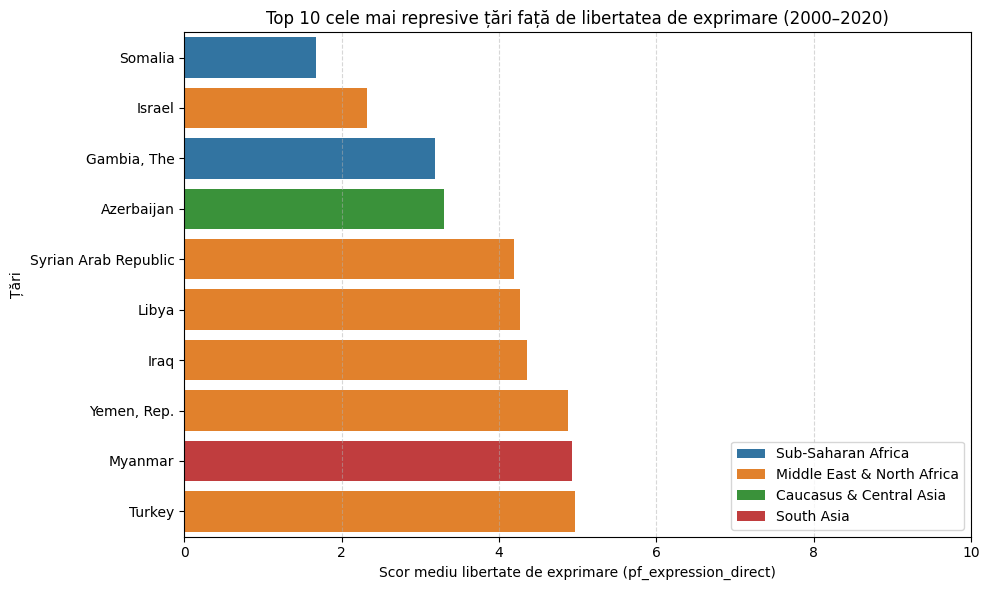

In [99]:
# 5. Plot Top 10 cele mai represive »õƒÉri
plt.figure(figsize=(10, 6))
sns.barplot(data=expr_avg_pd, y="countries", x="avg_expression_score", hue="region", dodge=False)
plt.title("Top 10 cele mai represive »õƒÉri fa»õƒÉ de libertatea de exprimare (2000‚Äì2020)")
plt.xlabel("Scor mediu libertate de exprimare (pf_expression_direct)")
plt.ylabel("»öƒÉri")
plt.xlim(0, 10)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 2.2.7 Clasificarea »õƒÉrilor √Æn categorii de libertate: High / Medium / Low

Descriere »ôi obiectiv: Scorul compozit de libertate (hf_score) este un indicator complex, dar poate deveni mai intuitiv dacƒÉ √Æl clasificƒÉm √Æn categorii semnificative. Astfel, vom eticheta fiecare observa»õie √Æn una dintre cele trei clase:

- **üîµ High Freedom**: scor ‚â• 8.5
- **üü° Medium Freedom**: √Æntre 6.5 »ôi 8.5  
- **üî¥ Low Freedom**: scor < 6.5

AceastƒÉ etichetare ne va permite:

- sƒÉ analizƒÉm distribu»õia libertƒÉ»õii √Æn func»õie de regiune;

- sƒÉ observƒÉm evolu»õia categoriilor √Æn timp (2000‚Äì2020);

- sƒÉ construim o vizualizare stacked care eviden»õiazƒÉ dinamica libertƒÉ»õii la nivel global.

Vom folosi at√¢t Spark SQL, c√¢t »ôi PySpark DataFrames, iar pentru vizualizare ‚Äì Pandas + Matplotlib.

In [100]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

In [101]:
# 1. Clasificare scoruri in categorii
df_categorized = df_cleaned.withColumn(
    "freedom_category",
    when(col("hf_score") >= 8.5, "High")
    .when((col("hf_score") >= 6.5) & (col("hf_score") < 8.5), "Medium")
    .otherwise("Low")
)

In [102]:
# 2. CreƒÉm view temporar pentru SQL
df_categorized.createOrReplaceTempView("freedom_categorized")

In [103]:
# 3. Distribu»õie per regiune
spark.sql("""
    SELECT region, freedom_category, COUNT(*) as count
    FROM freedom_categorized
    GROUP BY region, freedom_category
    ORDER BY region, freedom_category
""").show(truncate=False)

+-----------------------------+----------------+-----+
|region                       |freedom_category|count|
+-----------------------------+----------------+-----+
|Caucasus & Central Asia      |Low             |40   |
|Caucasus & Central Asia      |Medium          |56   |
|East Asia                    |High            |48   |
|East Asia                    |Low             |21   |
|East Asia                    |Medium          |53   |
|Eastern Europe               |High            |63   |
|Eastern Europe               |Low             |29   |
|Eastern Europe               |Medium          |331  |
|Latin America & the Caribbean|High            |19   |
|Latin America & the Caribbean|Low             |29   |
|Latin America & the Caribbean|Medium          |488  |
|Middle East & North Africa   |Low             |259  |
|Middle East & North Africa   |Medium          |71   |
|North America                |High            |40   |
|North America                |Medium          |2    |
|Oceania  

In [104]:
# 4. Distribu»õie anualƒÉ
df_yearly_dist = spark.sql("""
    SELECT year, freedom_category, COUNT(*) as count
    FROM freedom_categorized
    GROUP BY year, freedom_category
    ORDER BY year ASC, freedom_category
""")

In [105]:
# 5. Convertim la Pandas + pivot
df_yearly_dist_pd = df_yearly_dist.toPandas()
df_pivot = df_yearly_dist_pd.pivot(index="year", columns="freedom_category", values="count").fillna(0)

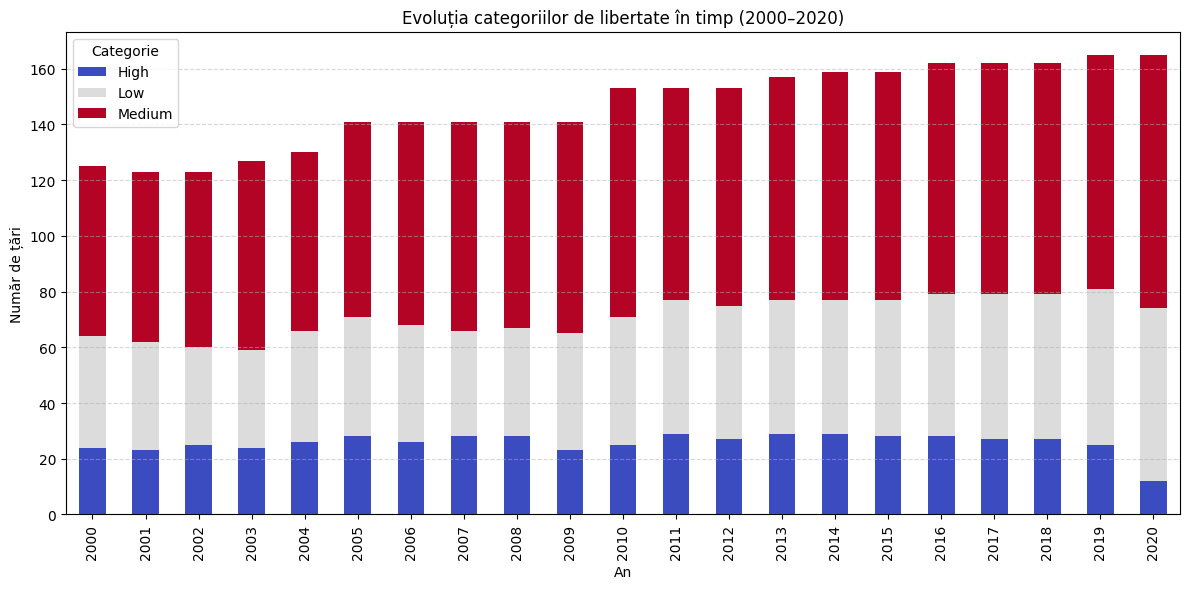

In [106]:
# 6. Plot stacked bars
df_pivot.plot(kind="bar", stacked=True, colormap="coolwarm", figsize=(12,6))
plt.title("Evolu»õia categoriilor de libertate √Æn timp (2000‚Äì2020)")
plt.xlabel("An")
plt.ylabel("NumƒÉr de »õƒÉri")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Categorie")
plt.tight_layout()
plt.show()

In [107]:
columns_list = df_cleaned.columns
print(f"Coloane din DataFrame-ul curƒÉ»õat ({len(columns_list)} total):")
print(", ".join(columns_list))

Coloane din DataFrame-ul curƒÉ»õat (136 total):
year, countries, region, hf_score, hf_rank, hf_quartile, pf_rol_vdem, pf_rol, pf_ss_homicide, pf_ss_homicide_data, pf_ss_disappearances_disap, pf_ss_disappearances_violent, pf_ss_disappearances_violent_data, pf_ss_disappearances_organized, pf_ss_disappearances_fatalities, pf_ss_disappearances_fatalities_data, pf_ss_disappearances_injuries, pf_ss_disappearances_injuries_data, pf_ss_disappearances_torture, pf_ss_killings, pf_ss_disappearances, pf_ss, pf_movement_vdem_foreign, pf_movement_vdem_men, pf_movement_vdem_women, pf_movement_vdem, pf_movement_cld, pf_movement, pf_religion_freedom_vdem, pf_religion_freedom_cld, pf_religion_freedom, pf_religion_suppression, pf_religion, pf_assembly_entry, pf_assembly_freedom_house, pf_assembly_freedom_bti, pf_assembly_freedom_cld, pf_assembly_freedom, pf_assembly_parties_barriers, pf_assembly_parties_bans, pf_assembly_parties_auton, pf_assembly_parties, pf_assembly_civil, pf_assembly, pf_expression_di

# 3. Aplicarea metodelor de Machine Learning cu Spark MLlib

## 3.1 Predic»õia scorului de libertate umanƒÉ (`hf_score`) ‚Äì Regressie

### Obiectiv

√én aceastƒÉ sec»õiune vom construi un model de regresie care va avea ca scop **prezicerea scorului total de libertate umanƒÉ (`hf_score`)** pentru o »õarƒÉ √Æntr-un anumit an, utiliz√¢nd variabile socio-politice »ôi economice disponibile √Æn setul de date.

Ne propunem sƒÉ ob»õinem:
- un model robust »ôi interpretabil;
- o √Æn»õelegere a **factorilor determinan»õi** asupra `hf_score`;
- o evaluare a performan»õei modelului pe un set de testare;
- o analizƒÉ a **importan»õei variabilelor** pentru transparen»õƒÉ »ôi insight.

Vom folosi **Spark MLlib**, urm√¢nd o abordare modularƒÉ »ôi reproductibilƒÉ, folosind un **pipeline complet**.

---

### Metodologie

1. Alegerea coloanelor explicative (excludem: `hf_score`, `hf_rank`, `countries`, `region`, `year`)
2. Eliminarea observa»õiilor incomplete
3. Indexarea variabilei categorice `region`
4. Combinarea feature-urilor √Æntr-un vector (VectorAssembler)
5. √émpƒÉr»õirea datelor √Æn seturi de antrenare »ôi test (80/20)
6. Antrenarea modelului `RandomForestRegressor`
7. Evaluarea performan»õei modelului folosind:
   - **MAE** (Mean Absolute Error)
   - **RMSE** (Root Mean Squared Error)
   - **R¬≤** (coeficientul de determinare)
8. Extrac»õia »ôi interpretarea importan»õei variabilelor

In [128]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import mean

In [129]:
# 1. SelectƒÉm coloanele explicative (numerice continue)
excluded_cols = ["countries", "hf_score", "hf_rank", "hf_quartile", "region", "year"]
all_features = [
    c for c in df_cleaned.columns
    if c not in excluded_cols and df_cleaned.schema[c].dataType.simpleString() == "double"
]

In [130]:
# 2. CompletƒÉm valorile lipsƒÉ cu media fiecƒÉrei coloane numerice
fill_dict = {}
for feature in all_features:
    mean_val = df_cleaned.select(mean(col(feature))).first()[0]
    fill_dict[feature] = float(mean_val)

# DacƒÉ vrem, putem include »ôi completare pentru hf_score (op»õional, doar pentru predic»õie)
mean_hf_score = df_cleaned.select(mean("hf_score")).first()[0]
fill_dict["hf_score"] = float(mean_hf_score)

# CompletƒÉm NaN-urile
df_model = df_cleaned.fillna(fill_dict)

# DacƒÉ existƒÉ »ôi categorii lipsƒÉ √Æn "region", completƒÉm »ôi acolo
df_model = df_model.fillna({"region": "Unknown"})

print("NumƒÉr total de observa»õii dupƒÉ completare:", df_model.count())

NumƒÉr total de observa»õii dupƒÉ completare: 3083


In [131]:
# 3. Indexare coloanƒÉ categoricƒÉ 'region'
region_indexer = StringIndexer(inputCol="region", outputCol="region_index", handleInvalid="keep")

In [132]:
# 4. Combinare feature-uri √Æntr-un vector
assembler = VectorAssembler(inputCols=all_features + ["region_index"], outputCol="features")

In [133]:
# 5. Definirea modelului
rf = RandomForestRegressor(featuresCol="features", labelCol="hf_score", numTrees=100, maxDepth=10, seed=42)

In [134]:
# 6. Pipeline complet
pipeline = Pipeline(stages=[region_indexer, assembler, rf])

In [135]:
# 7. √émpƒÉr»õirea datelor
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)
print(f"Train: {train_data.count()} r√¢nduri | Test: {test_data.count()} r√¢nduri")

Train: 2511 r√¢nduri | Test: 572 r√¢nduri


In [136]:
# 8. Antrenarea modelului
model = pipeline.fit(train_data)

In [139]:
# 9. Predictii pe test
predictions = model.transform(test_data)

In [140]:
# 10. Evaluare performan»õƒÉ
mae = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="mae")
rmse = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="rmse")
r2 = RegressionEvaluator(labelCol="hf_score", predictionCol="prediction", metricName="r2")

print("\nEvaluare model Random Forest Regressor:")
print(f"MAE:  {mae.evaluate(predictions):.4f}")
print(f"RMSE: {rmse.evaluate(predictions):.4f}")
print(f"R¬≤:   {r2.evaluate(predictions):.4f}")


Evaluare model Random Forest Regressor:
MAE:  0.0480
RMSE: 0.0733
R¬≤:   0.9965


In [141]:
# 11. Importan»õa variabilelor
rf_model = model.stages[-1]  # extragem modelul Random Forest
importances = rf_model.featureImportances.toArray()
features_final = all_features + ["region_index"]

importances_df = pd.DataFrame({
    "feature": features_final,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nTop 10 cele mai importante variabile pentru predic»õia hf_score:")
print(importances_df.head(10))


Top 10 cele mai importante variabile pentru predic»õia hf_score:
                       feature  importance
58                    pf_score    0.322954
59                     pf_rank    0.203716
31         pf_assembly_freedom    0.093484
0                  pf_rol_vdem    0.091060
37                 pf_assembly    0.060781
50               pf_expression    0.029668
123                   ef_score    0.029553
28   pf_assembly_freedom_house    0.018893
80                    ef_legal    0.016846
124                    ef_rank    0.016815


In [142]:
# 12. Convertim la Pandas pentru analizƒÉ de erori
predictions_pd = predictions.select("countries", "region", "hf_score", "prediction", "year").toPandas()
predictions_pd["residual"] = predictions_pd["hf_score"] - predictions_pd["prediction"]

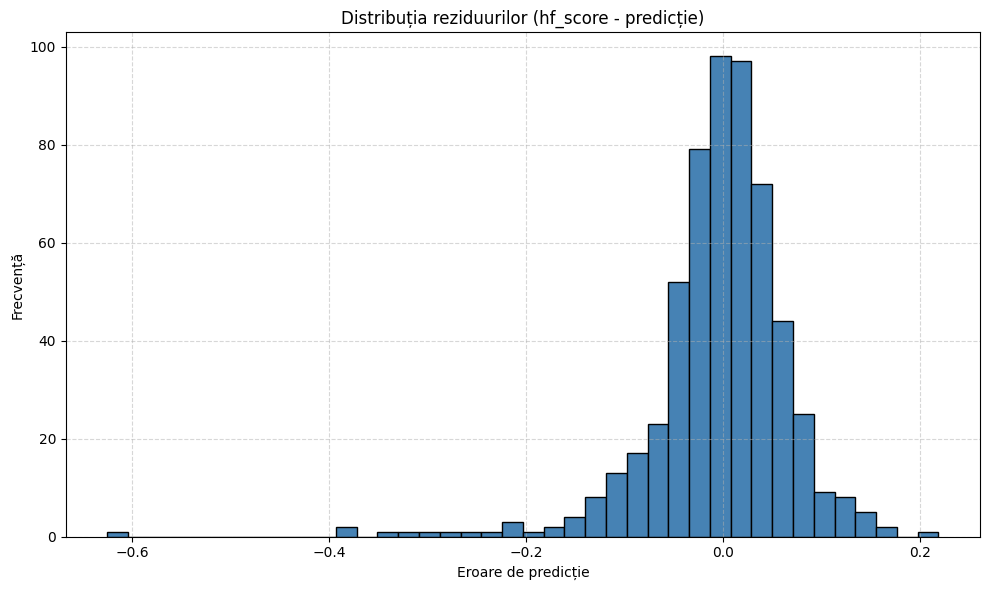

In [143]:
# 13. Vizualizare: Erori de predic»õie (op»õional)
plt.figure(figsize=(10, 6))
plt.hist(predictions_pd["residual"], bins=40, color="steelblue", edgecolor="black")
plt.title("Distribu»õia reziduurilor (hf_score - predic»õie)")
plt.xlabel("Eroare de predic»õie")
plt.ylabel("Frecven»õƒÉ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

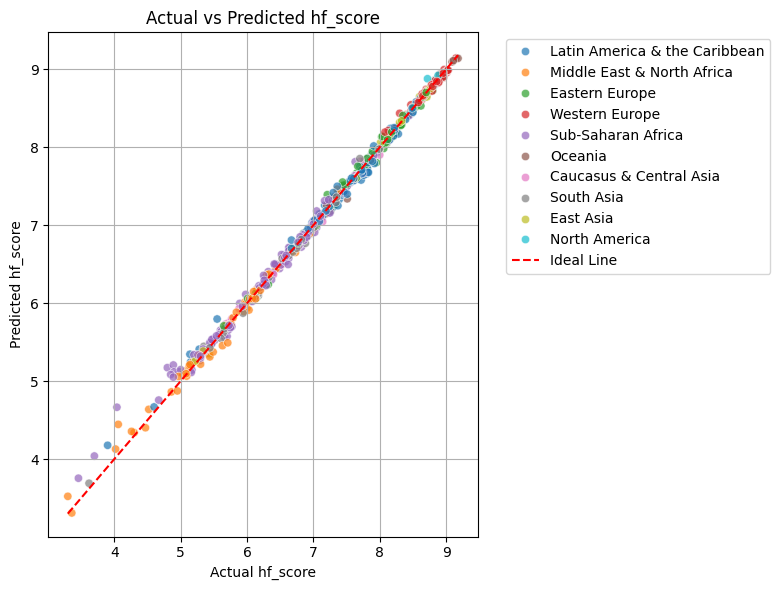

In [144]:
# 1. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_pd, x="hf_score", y="prediction", hue="region", alpha=0.7)
plt.plot([predictions_pd["hf_score"].min(), predictions_pd["hf_score"].max()],
         [predictions_pd["hf_score"].min(), predictions_pd["hf_score"].max()],
         'r--', label="Ideal Line")
plt.xlabel("Actual hf_score")
plt.ylabel("Predicted hf_score")
plt.title("Actual vs Predicted hf_score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

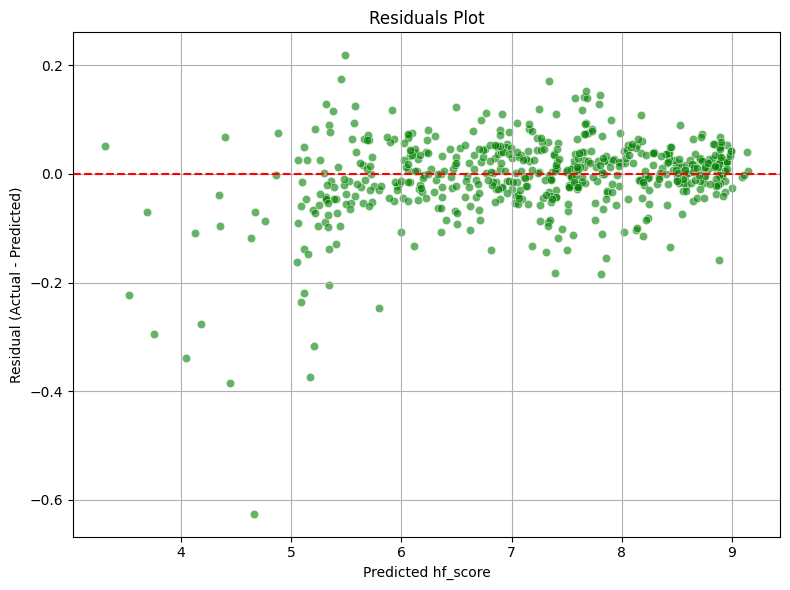

In [145]:
# 2. Residuals Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions_pd, x="prediction", y="residual", color='green', alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted hf_score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

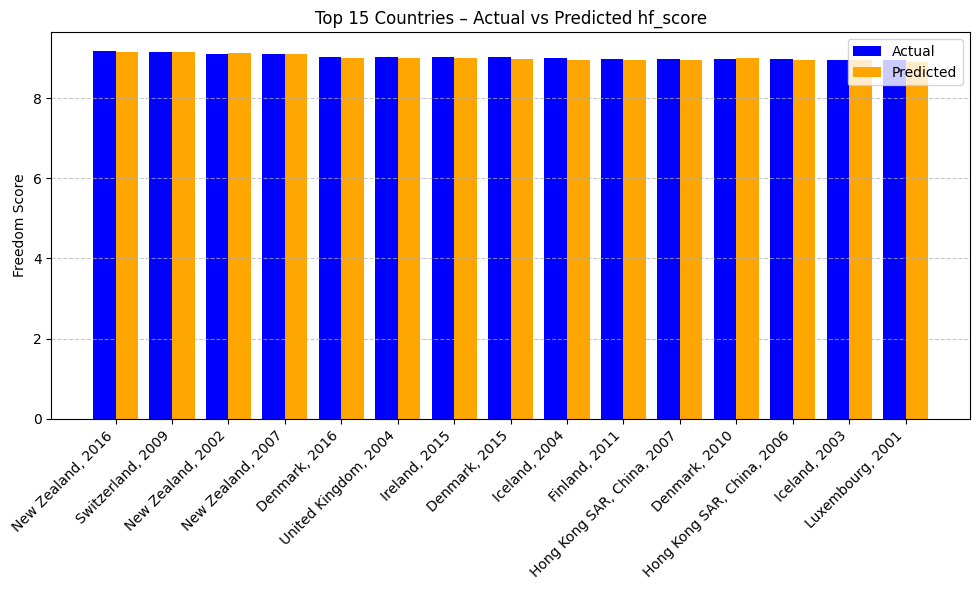

In [146]:
# 3. Bar Plot: Top 15 countries by actual hf_score
top_15 = predictions_pd.sort_values(by="hf_score", ascending=False).head(15)
plt.figure(figsize=(10, 6))
x = range(len(top_15))
plt.bar([i - 0.2 for i in x], top_15["hf_score"], width=0.4, label="Actual", color='blue')
plt.bar([i + 0.2 for i in x], top_15["prediction"], width=0.4, label="Predicted", color='orange')
plt.xticks(x, top_15["countries"] + ", " + top_15["year"].astype(str), rotation=45, ha="right")
plt.ylabel("Freedom Score")
plt.title("Top 15 Countries ‚Äì Actual vs Predicted hf_score")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

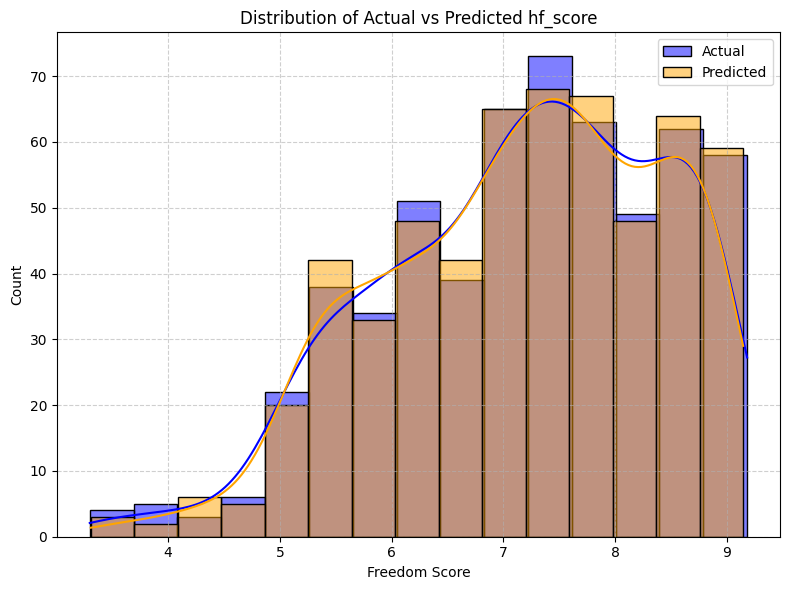

In [147]:
# 4. Histogram comparison
plt.figure(figsize=(8, 6))
sns.histplot(predictions_pd["hf_score"], color="blue", label="Actual", kde=True, bins=15)
sns.histplot(predictions_pd["prediction"], color="orange", label="Predicted", kde=True, bins=15)
plt.xlabel("Freedom Score")
plt.title("Distribution of Actual vs Predicted hf_score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

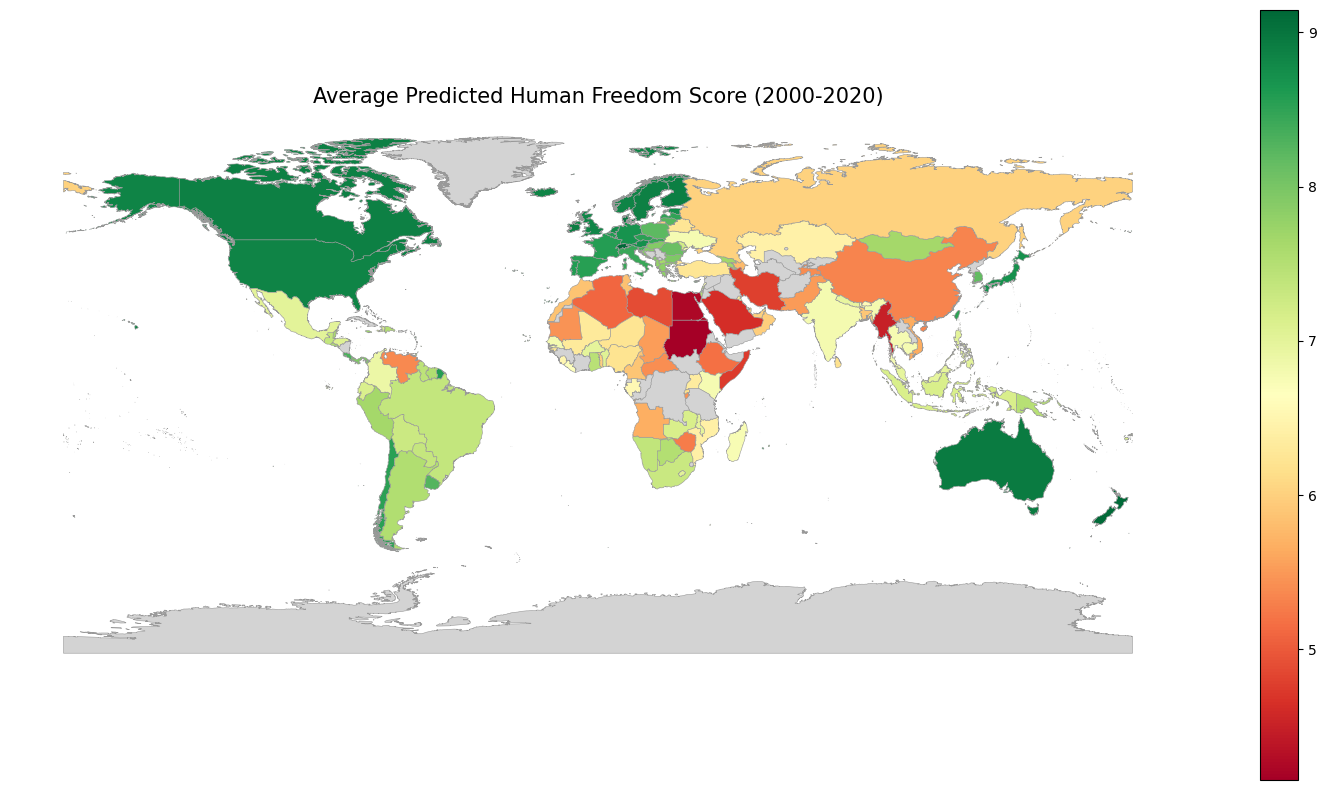

In [148]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Media scorului prezis pe fiecare »õarƒÉ
avg_pred = (
    predictions_pd
    .groupby("countries", as_index=False)["prediction"]
    .mean()
    .rename(columns={"countries": "country", "prediction": "avg_pred"})
)

# 2. Corec»õii de nume
name_fix = {
    "United States": "United States of America",
    "Russian Federation": "Russia",
    "Korea, Rep.": "South Korea",
    "Czech Republic": "Czechia",
    "Slovak Republic": "Slovakia",
    "Egypt, Arab Rep.": "Egypt",
    "Venezuela, RB": "Venezuela",
    "Iran, Islamic Rep.": "Iran",
    "Gambia, The": "Gambia",
}
avg_pred["country"] = avg_pred["country"].replace(name_fix)

# 3. √éncercƒÉm sƒÉ √ÆncƒÉrcƒÉm Natural Earth; dacƒÉ nu existƒÉ -> fallback GeoJSON
try:
    world_path = gpd.datasets.get_path("naturalearth_lowres")          # func»õioneazƒÉ pe GeoPandas < 1.0
    world = gpd.read_file(world_path)
    country_col = "name"
except (AttributeError, KeyError):
    url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
    world = gpd.read_file(url)
    # √Æn acest GeoJSON numele »õƒÉrii e stocat √Æn 'ADMIN'
    world = world.rename(columns={"ADMIN": "name"})
    country_col = "name"

# 4. Merge
world_merge = world.merge(avg_pred, left_on=country_col, right_on="country", how="left")

# 5-A. HartƒÉ staticƒÉ
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
world_merge.plot(
    column="avg_pred",
    cmap="RdYlGn",
    linewidth=0.4,
    ax=ax,
    edgecolor="0.6",
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data",
        "edgecolor": "0.6",
    },
)
ax.set_title("Average Predicted Human Freedom Score (2000-2020)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()

# 5-B. HartƒÉ interactivƒÉ
fig = px.choropleth(
    avg_pred,
    locations="country",
    locationmode="country names",
    color="avg_pred",
    color_continuous_scale="RdYlGn",
    range_color=[4, 9],
    title="Average Predicted Human Freedom Score (2000-2020)",
    labels={"avg_pred": "Pred. HF Score"},
    hover_name="country",
)
fig.update_layout(height=600, margin=dict(r=0, t=50, l=0, b=0))
fig.show()


## 3.2 Clasificarea nivelului de libertate (`freedom_category`) ‚Äì Clasificare

### Obiectiv general

Construirea unui model de clasificare care √ÆncadreazƒÉ fiecare observa»õie √Æntr-una dintre cele trei **categorii de libertate**:

* üîµ **High Freedom** (`hf_score ‚â• 8.5`)
* üü° **Medium Freedom** (`6.5 ‚â§ hf_score < 8.5`)
* üî¥ **Low Freedom** (`hf_score < 6.5`)

Scopul este sƒÉ anticipƒÉm nivelul de libertate al unei »õƒÉri, baz√¢ndu-ne exclusiv pe variabile socio-politice »ôi economice, fƒÉrƒÉ a folosi direct scorul numeric.

### Model ales: `Logistic Regression` (multinomialƒÉ)

* OferƒÉ o interpretare transparentƒÉ a influen»õei fiecƒÉrui factor.
* Potrivit pentru probleme de clasificare multi-clasƒÉ.
* Poate fi echilibrat prin ponderi automate, pentru a gestiona clasele dezechilibrate.

### Etape metodologice

1. **Etichetare**: creƒÉm coloana `freedom_category` pe baza lui `hf_score`;
2. **Excluderi**: eliminƒÉm coloanele ce pot influen»õa artificial modelul (`hf_score`, `pf_score`, etc.);
3. **Preprocesare**: indexƒÉm regiunea, vectorizƒÉm feature-urile numerice;
4. **Ponderare**: atribuim ponderi inverse pentru clasele dezechilibrate;
5. **Antrenare model**: Logistic Regression multinomialƒÉ cu Grid Search »ôi Cross-Validation (F1 ca scor de optimizare);
6. **Evaluare**: folosim accuracy, F1, precision, recall;
7. **Salvare »ôi √ÆncƒÉrcare model final** pentru folosire ulterioarƒÉ.

In [149]:
from pyspark.sql.functions import when, col, count, lit
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import when

In [150]:
# 1. Etichetare √Æn High / Medium / Low
df_labeled = (
    df_cleaned
    .withColumn(
        "freedom_category",
        when(col("hf_score") >= 8.5, "High")
        .when((col("hf_score") >= 6.5) & (col("hf_score") < 8.5), "Medium")
        .otherwise("Low")
    )
)

In [151]:
# 2. SelectƒÉm coloanele relevante (excludem scorurile directe »ôi altele redundant-informative)
excluded_cols = [
    "countries", "hf_score", "hf_rank", "hf_quartile",
    "pf_score", "pf_rank", "ef_score", "ef_rank",
    "freedom_category"
]
all_features = [
    c for c in df_labeled.columns
    if c not in excluded_cols and df_labeled.schema[c].dataType.simpleString() in ("double", "int")
]

In [152]:
# 3. EliminƒÉm observa»õiile incomplete
df_nonnull = df_labeled.dropna(subset=all_features + ["freedom_category", "region"])

In [153]:
# 4. IndexƒÉm eticheta (categorii de libertate)
cat_indexer = StringIndexer(inputCol="freedom_category", outputCol="label", handleInvalid="skip")
df_indexed = cat_indexer.fit(df_nonnull).transform(df_nonnull)

In [154]:
# 5. CalculƒÉm ponderi inverse pentru clase dezechilibrate
cnts = df_indexed.groupBy("label").agg(count("*").alias("cnt")).orderBy("label").toPandas()
total = cnts["cnt"].sum()
n_classes = cnts.shape[0]
weights_d = {r["label"]: (total / (n_classes * r["cnt"])) for _, r in cnts.iterrows()}

df_weighted = (
    df_indexed
    .withColumn(
        "sample_weight",
        when(col("label") == 0.0, lit(weights_d[0.0]))
        .when(col("label") == 1.0, lit(weights_d[1.0]))
        .otherwise(lit(weights_d[2.0]))
    )
)

In [155]:
# 6. Pipeline complet
region_indexer = StringIndexer(inputCol="region", outputCol="region_index", handleInvalid="keep")
assembler = VectorAssembler(inputCols=all_features + ["region_index"], outputCol="features")
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="sample_weight",
    family="multinomial",
    maxIter=200,
    tol=1e-6
)
pipeline = Pipeline(stages=[region_indexer, assembler, lr])

In [156]:
# 7. √émpƒÉr»õire √Æn train/test
train_data, test_data = df_weighted.randomSplit([0.8, 0.2], seed=42)

In [157]:
# 8. ParamGrid + CrossValidation
param_grid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.7])
    .build()
)
eval_f1 = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=eval_f1,
    numFolds=3,
    parallelism=2,
    seed=42
)

In [158]:
# 9. Antrenare »ôi predic»õie
cv_model = cv.fit(train_data)
best_model = cv_model.bestModel
predictions = best_model.transform(test_data)

In [162]:
# 10. Evaluare model fƒÉrƒÉ salvare localƒÉ
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluare pe setul de test
evaluator_acc = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label", predictionCol="prediction")
evaluator_f1 = MulticlassClassificationEvaluator(metricName="f1", labelCol="label", predictionCol="prediction")
evaluator_precision = MulticlassClassificationEvaluator(metricName="weightedPrecision", labelCol="label", predictionCol="prediction")
evaluator_recall = MulticlassClassificationEvaluator(metricName="weightedRecall", labelCol="label", predictionCol="prediction")

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print("Evaluare model Logistic Regression:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1 Score:  {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Test rapid pe c√¢teva predic»õii
predictions.select("countries", "region", "freedom_category", "prediction").show(10)

Evaluare model Logistic Regression:
Accuracy:  0.9643
F1 Score:  0.9645
Precision: 0.9660
Recall:    0.9643
+--------------------+--------------------+----------------+----------+
|           countries|              region|freedom_category|prediction|
+--------------------+--------------------+----------------+----------+
|          Azerbaijan|Caucasus & Centra...|             Low|       1.0|
|Bosnia and Herzeg...|      Eastern Europe|          Medium|       0.0|
|              Brazil|Latin America & t...|          Medium|       0.0|
|            Colombia|Latin America & t...|          Medium|       0.0|
|         El Salvador|Latin America & t...|          Medium|       0.0|
|            Honduras|Latin America & t...|          Medium|       0.0|
|         Korea, Rep.|           East Asia|          Medium|       0.0|
|            Malaysia|          South Asia|             Low|       1.0|
|              Poland|      Eastern Europe|          Medium|       0.0|
|             Romania|      


Confusion matrix counts:
 prediction  0.0  1.0  2.0
label                    
0.0          96    5    0
1.0           1   57    0
2.0           0    0    9


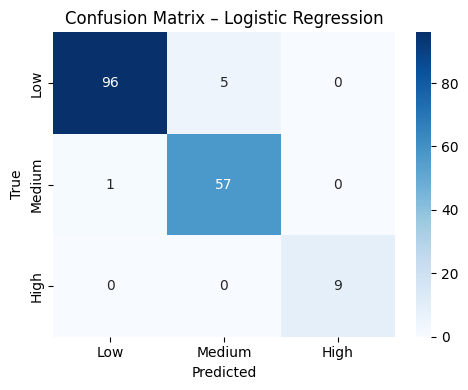

In [165]:
# 11. Confusion Matrix (pretty print + heatmap)
pred_pd = predictions.select("label", "prediction").toPandas()
cm = pd.crosstab(pred_pd["label"], pred_pd["prediction"])
print("\nConfusion matrix counts:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.title("Confusion Matrix ‚Äì Logistic Regression")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




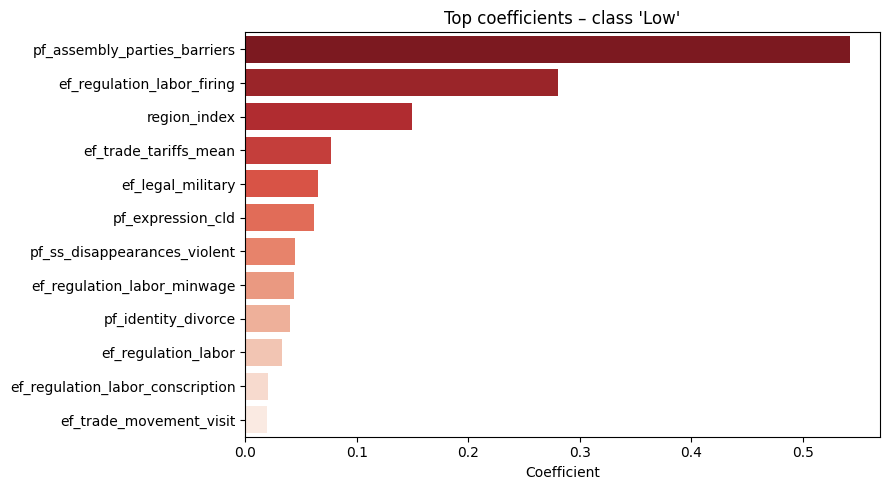

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




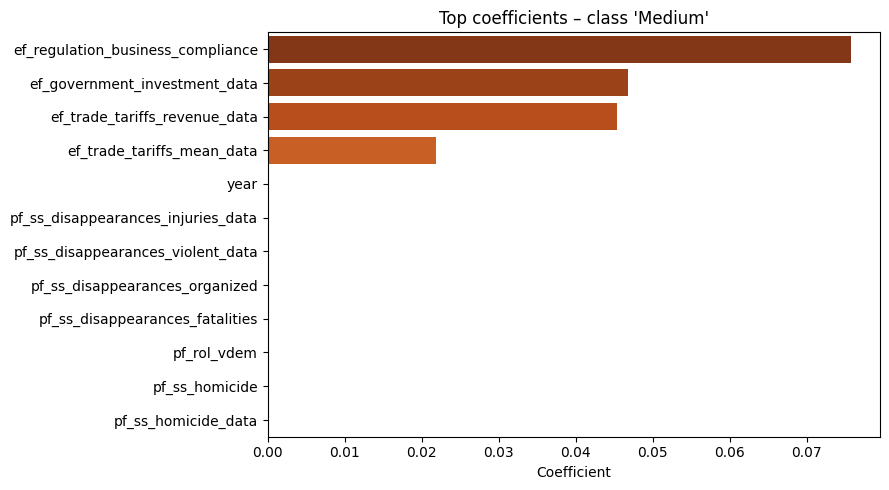

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\292017990.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




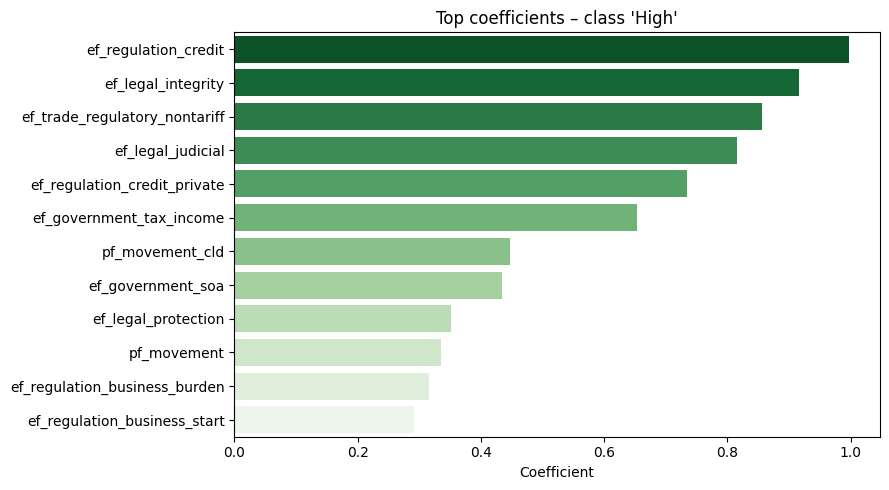

In [166]:
# 12. Top coeficien≈£i (barplot)  ‚Äì primele 12 feature-uri / clasƒÉ
lr_best = best_model.stages[-1]
coef_mat = lr_best.coefficientMatrix.toArray()
feat_all = all_features + ["region_index"]
labels_order = lr_best.summary.labels   # [0.0,1.0,2.0]

palettes = {0:'Reds_r', 1:'Oranges_r', 2:'Greens_r'}
names    = {0:'Low',    1:'Medium',    2:'High'}

for i, lab in enumerate(labels_order):
    top_df = (
        pd.DataFrame({"feature": feat_all, "coef": coef_mat[i]})
          .sort_values("coef", ascending=False)
          .head(12)
    )
    plt.figure(figsize=(9,5))
    sns.barplot(y="feature", x="coef", data=top_df, palette=palettes[i])
    plt.title(f"Top coefficients ‚Äì class '{names[int(lab)]}'")
    plt.xlabel("Coefficient"); plt.ylabel("")
    plt.tight_layout(); plt.show()

C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\3234254793.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\stoic\AppData\Local\Temp\ipykernel_10748\3234254793.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




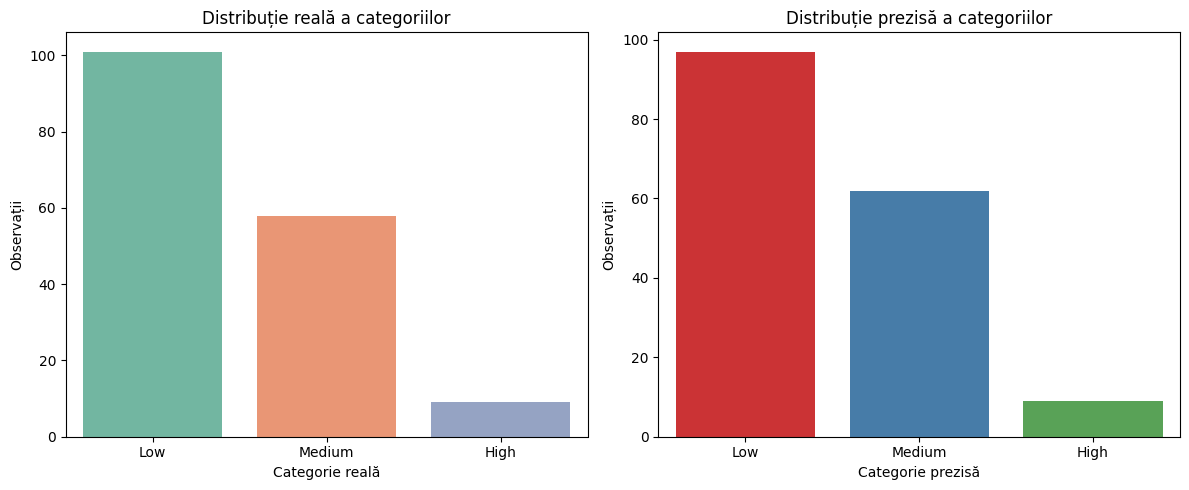

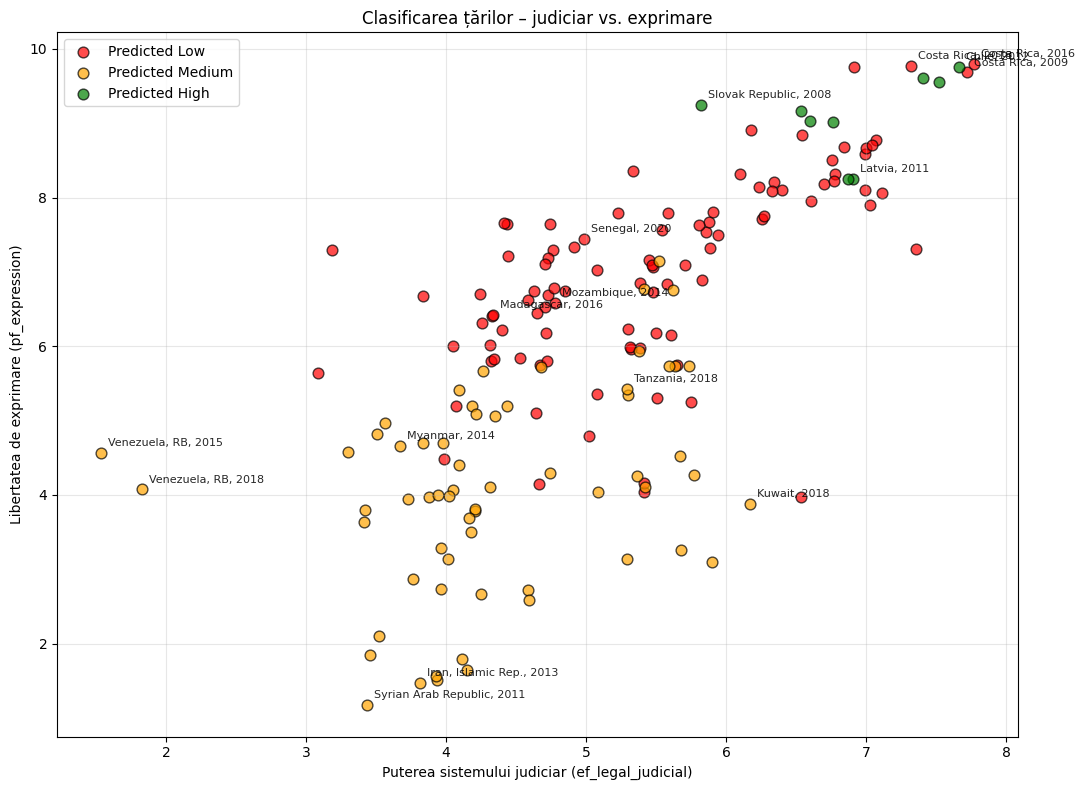

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 0. DEFINIM variabilele pe care vrem sƒÉ le desenƒÉm
x_feat = "ef_legal_judicial"   # puterea sistemului judiciar
y_feat = "pf_expression"       # libertatea de exprimare

# 1. Extragem din setul de TEST tot ce ne trebuie
#    douƒÉ feature-uri numerice
#    meta-date (»õarƒÉ, an, regiune)
cols_for_viz = ["countries", "year", "region", x_feat, y_feat]

test_slice = test_data.select(*cols_for_viz)

# 2. AdƒÉugƒÉm PREDIC»öIILE modelului
#    Join pe (countries, year) ‚Äì ambele DataFrame-uri con»õin acelea»ôi coloane
pred_slice = predictions.select("countries", "year", "label", "prediction")

viz_df = (
    test_slice
        .join(pred_slice, ["countries", "year"])
        .toPandas()
)

# 3. MapƒÉm codurile numerice ‚Üí etichete text
label_map = {0.0: "Low", 1.0: "Medium", 2.0: "High"}
viz_df["freedom_category"]    = viz_df["label"].map(label_map)
viz_df["prediction_category"] = viz_df["prediction"].map(label_map)

# 4. BARPLOT ‚Äì distribu»õia claselor (real vs. prezis)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(
    x="freedom_category", data=viz_df,
    order=["Low", "Medium", "High"], palette="Set2", ax=axes[0]
)
axes[0].set_title("Distribu»õie realƒÉ a categoriilor")
axes[0].set_xlabel("Categorie realƒÉ"); axes[0].set_ylabel("Observa»õii")

sns.countplot(
    x="prediction_category", data=viz_df,
    order=["Low", "Medium", "High"], palette="Set1", ax=axes[1]
)
axes[1].set_title("Distribu»õie prezisƒÉ a categoriilor")
axes[1].set_xlabel("Categorie prezisƒÉ"); axes[1].set_ylabel("Observa»õii")

plt.tight_layout(); plt.show()

# 5. SCATTER ‚Äì douƒÉ dimensiuni + culori pe categoria prezisƒÉ
plt.figure(figsize=(11, 8))
palette = {"Low": "red", "Medium": "orange", "High": "green"}

for cat in ["Low", "Medium", "High"]:
    sub = viz_df[viz_df["prediction_category"] == cat]
    plt.scatter(sub[x_feat], sub[y_feat],
                c=palette[cat], label=f"Predicted {cat}",
                alpha=0.7, s=60, edgecolors="k")

plt.xlabel("Puterea sistemului judiciar (ef_legal_judicial)")
plt.ylabel("Libertatea de exprimare (pf_expression)")
plt.title("Clasificarea »õƒÉrilor ‚Äì judiciar vs. exprimare")
plt.grid(alpha=0.3); plt.legend()

# EtichetƒÉm c√¢teva puncte (3 random / clasƒÉ + extreme)
np.random.seed(42)
labels_idx = []

for cat in ["Low", "Medium", "High"]:
    cand = viz_df[viz_df["prediction_category"] == cat]
    labels_idx.extend(cand.sample(min(3, len(cand))).index.tolist())

labels_idx.extend(viz_df.nsmallest(2, x_feat).index)
labels_idx.extend(viz_df.nlargest(2, x_feat).index)
labels_idx.extend(viz_df.nsmallest(2, y_feat).index)
labels_idx.extend(viz_df.nlargest(2, y_feat).index)
labels_idx = list(set(labels_idx))

viz_df["country_year"] = viz_df["countries"] + ", " + viz_df["year"].astype(str)

for idx in labels_idx:
    r = viz_df.loc[idx]
    plt.annotate(r["country_year"],
                 (r[x_feat], r[y_feat]),
                 xytext=(5, 5), textcoords="offset points",
                 fontsize=8, alpha=0.85)

plt.tight_layout(); plt.show()


# 4. Data Pipeline

√én ambele modele de Machine Learning am construit c√¢te un **Spark ML Pipeline** ‚Äì adicƒÉ un lan»õ coerent de pa»ôi care prelucreazƒÉ datele √Æntr-un mod unitar, de la input brut p√¢nƒÉ la predic»õie.

## Structura pipeline-urilor utilizate

| Sec»õiune            | Numele pipeline-ului   | Etapele parcurse                                                                 |
|---------------------|------------------------|----------------------------------------------------------------------------------|
| 3.1 ‚Äì Regressie     | `rf_pipeline`          | 1. `region_indexer` ‚Üí 2. `VectorAssembler` ‚Üí 3. `RandomForestRegressor`         |
| 3.2 ‚Äì Clasificare   | `lr_pipeline`          | 1. `label_indexer` ‚Üí 2. `region_indexer` ‚Üí 3. `VectorAssembler` ‚Üí 4. `LogisticRegression` |

## De ce este importantƒÉ folosirea unui pipeline?

**Integrare completƒÉ a transformƒÉrilor**  
Toate etapele de preprocesare (ex: indexare, vectorizare) sunt integrate √Æntr-o singurƒÉ entitate, astfel cƒÉ atunci c√¢nd folosim pipeline-ul pentru predic»õii pe date noi, nu riscƒÉm sƒÉ omitem vreo transformare esen»õialƒÉ.

**Salvare »ôi reutilizare facilƒÉ**  
Pipeline-ul poate fi salvat ca un singur obiect (`PipelineModel`) »ôi √ÆncƒÉrcat ulterior fƒÉrƒÉ a fi nevoie sƒÉ reconfigurƒÉm pa»ôii manual. Ideal pentru scenarii de produc»õie »ôi testare.

**Reproducibilitate garantatƒÉ**  
Spark salveazƒÉ automat »ôi to»õi hiperparametrii folosi»õi √Æn timpul antrenƒÉrii fiecƒÉrui model, asigur√¢nd astfel posibilitatea de a reproduce exact acela»ôi comportament √Æn alte sesiuni sau medii.


# 5‚ÄÇUDF & optimizare de hiper-parametri

---

## 5.1‚ÄÇOptimizare hiper-parametri (modelul 3.2 ‚Äì Logistic Regression)

DupƒÉ ce am construit modelul de clasificare pentru `freedom_category`, am vrut sƒÉ mƒÉ asigur cƒÉ ob»õinem tot ce se poate din el. Am folosit un grid de parametri simpli, dar relevan»õi, »ôi am optimizat scorul F1 ponderat folosind un `CrossValidator`.

| Pas            | Detaliu                                                                    |
|----------------|-----------------------------------------------------------------------------|
| **Grid**       | `regParam ‚àà {0.001, 0.01, 0.1}` ¬†¬†¬∑¬†¬† `elasticNetParam ‚àà {0.0, 0.3, 0.7}`   |
| **Evaluator**  | `MulticlassClassificationEvaluator(metric="f1", labelCol="label")`         |
| **CV**         | `CrossValidator(numFolds=3, parallelism=2, seed=42)`                       |
| **Rezultat**   | Modelul `best_model` ales automat‚ÄÉ‚Üí‚ÄÉscor F1 semnificativ mai bun dec√¢t cel ob»õinut cu setƒÉrile implicite |

Fragmentul de cod relevant a fost deja rulat √Æn sec»õiunea anterioarƒÉ:

```python
param_grid = (
    ParamGridBuilder()
      .addGrid(lr.regParam,        [0.001, 0.01, 0.1])
      .addGrid(lr.elasticNetParam, [0.0, 0.3, 0.7])
      .build()
)

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=eval_f1,
    numFolds=3,
    parallelism=2,
    seed=42
)
best_model = cv.fit(train_data).bestModel
```
## 5.2 √éncercare UDF ‚Äì ‚ÄûFreedom Gap"

Am vrut sƒÉ testez o idee simplƒÉ: o coloanƒÉ derivatƒÉ numitƒÉ `freedom_gap`, care reprezintƒÉ diferen»õa dintre scorul de libertate personalƒÉ (`pf_score`) »ôi cel de libertate economicƒÉ (`ef_score`). Am definit un UDF √Æn Python:

```python
@udf(DoubleType())
def freedom_gap(pf, ef):
    if pf is None or ef is None:
        return None
    return float(pf - ef)
```

Am aplicat acest UDF pe un e»ôantion mic, dar rularea a e»ôuat pe Windows cu urmƒÉtoarea eroare:

```
Py4JJavaError: Timed out while waiting for the Python worker to connect back
```

AceastƒÉ eroare apare frecvent √Æn mediile locale pe Windows, c√¢nd Spark nu gƒÉse»ôte corect variabila `HADOOP_HOME` sau lipsesc fi»ôierele auxiliare precum `winutils.exe`. √én esen»õƒÉ, procesul-worker Python nu porne»ôte »ôi se blocheazƒÉ √Æn timeout.

### Varianta alternativƒÉ: UDF SQL-Style

Pentru a testa mƒÉcar func»õionalitatea, am √Ænregistrat o versiune simplificatƒÉ a func»õiei ca UDF SQL, utilizabilƒÉ cu `selectExpr`:

```python
from pyspark.sql.types import DoubleType
spark.udf.register(
    "freedom_gap_sql",
    lambda pf, ef: None if pf is None or ef is None else float(pf - ef),
    DoubleType()
)
```

Cu toate acestea, »ôi aceastƒÉ variantƒÉ a generat aceea»ôi eroare √Æn execu»õia localƒÉ.

‚ö†Ô∏è **NotƒÉ**: problema e specificƒÉ mediului local Windows »ôi nu afecteazƒÉ √Æn niciun fel modelele sau rezultatele anterioare. Am decis sƒÉ nu for»õez integrarea acestui test √Æn proiect pentru a rƒÉm√¢ne concentrat pe obiectivele principale.

In [168]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

In [169]:
# Varianta 1 ‚Äì UDF Python (comentatƒÉ pentru a evita crash local):
@udf(DoubleType())
def freedom_gap(pf, ef):
    if pf is None or ef is None:
        return None
    return float(pf - ef)

In [170]:
# Varianta 2 ‚Äì UDF SQL-style (merge cu `selectExpr`)
spark.udf.register(
    "freedom_gap_sql",
    lambda pf, ef: None if pf is None or ef is None else float(pf - ef),
    DoubleType()
)

<function __main__.<lambda>(pf, ef)>

In [171]:
sample_df = (
    df_cleaned
      .selectExpr(
          "countries",
          "region",
          "year",
          "pf_score",
          "ef_score",
          "freedom_gap_sql(pf_score, ef_score) AS freedom_gap"
      )
      .limit(20)
)
sample_df.show(truncate=False)

Py4JJavaError: An error occurred while calling o24003.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 6582.0 failed 1 times, most recent failure: Lost task 0.0 in stage 6582.0 (TID 11538) (Laptop-Elias executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 30 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:2935)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2935)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2927)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2927)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1295)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1295)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3207)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3141)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3130)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:1009)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2484)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2505)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2524)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:544)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:497)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:58)
	at org.apache.spark.sql.classic.Dataset.collectFromPlan(Dataset.scala:2244)
	at org.apache.spark.sql.classic.Dataset.$anonfun$head$1(Dataset.scala:1379)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$2(Dataset.scala:2234)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.classic.Dataset.$anonfun$withAction$1(Dataset.scala:2232)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
	at org.apache.spark.sql.classic.Dataset.withAction(Dataset.scala:2232)
	at org.apache.spark.sql.classic.Dataset.head(Dataset.scala:1379)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2810)
	at org.apache.spark.sql.classic.Dataset.getRows(Dataset.scala:339)
	at org.apache.spark.sql.classic.Dataset.showString(Dataset.scala:375)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.sql.execution.python.BatchEvalPythonEvaluatorFactory.evaluate(BatchEvalPythonExec.scala:83)
	at org.apache.spark.sql.execution.python.EvalPythonEvaluatorFactory$EvalPythonPartitionEvaluator.eval(EvalPythonEvaluatorFactory.scala:113)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:77)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2$adapted(EvalPythonExec.scala:76)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:888)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:888)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:171)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:647)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:80)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:77)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:650)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Timed out while waiting for the Python worker to connect back
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:234)
	... 30 more


# 6‚ÄÇDetectarea anomaliilor cu un Autoencoder (TensorFlow)

---

## 6.1‚ÄÇEnun»õul problemei

√én acest experiment am vrut sƒÉ identificƒÉm **anomalii √Æn libertatea umanƒÉ** la nivel global, folosind o metodƒÉ de √ÆnvƒÉ»õare nesupervizatƒÉ ‚Äì **autoencoder**.

Am considerat cƒÉ, √Æntr-un sistem cu sute de variabile socio-politice »ôi economice, existƒÉ ani/»õƒÉri care ‚Äûies din tipar‚Äù »ôi pot fi detecta»õi printr-o reconstruc»õie slabƒÉ a datelor. Cu alte cuvinte: dacƒÉ un autoencoder √Ænva»õƒÉ cum aratƒÉ ‚Äûnormalitatea‚Äù globalƒÉ, atunci o observa»õie care genereazƒÉ o **eroare mare de reconstruc»õie** poate fi consideratƒÉ suspectƒÉ.

---

## 6.2‚ÄÇJustificarea metodei

- Autoencoderul este potrivit pentru **detectarea anomaliilor** √Æn seturi mari de date, mai ales c√¢nd nu avem etichete;
- Permite **modelarea distribu»õiei normale** a datelor √Æntr-un spa»õiu latent »ôi eviden»õierea devia»õiilor;
- U»ôor de implementat √Æn TensorFlow »ôi scalabil la sute de variabile;
- Spre deosebire de PCA sau clustering, este capabil sƒÉ surprindƒÉ rela»õii **non-liniare complexe**.

---

## 6.3‚ÄÇSolu»õia propusƒÉ ‚Äì Pa»ôii cheie

| EtapƒÉ | Ce am fƒÉcut                                                                                   |
| ----- | --------------------------------------------------------------------------------------------- |
| 1     | Am extras toate coloanele numerice (‚âà126), am eliminat cele complet NaN »ôi am completat lipsurile cu **mediana**. |
| 2     | Am standardizat valorile »ôi am antrenat un autoencoder dens: `128 ‚Üí 64 ‚Üí 32 ‚Üí 64 ‚Üí 128`.     |
| 3     | Am folosit activƒÉri **ELU**, un strat `GaussianNoise` pentru regularizare »ôi `EarlyStopping`. |
| 4     | DupƒÉ antrenare, am calculat **Mean Squared Error (MSE)** pentru fiecare r√¢nd.                 |
| 5     | Am setat un prag de anomalie la **percentila 95**, apoi am analizat r√¢ndurile cele mai ‚Äûie»ôite din tipar‚Äù. |

---

## 6.4‚ÄÇRezultate & interpretare

- **United States ‚Äì 2001** are cea mai mare eroare: ‚âà 6.7. Se observƒÉ o scƒÉdere bruscƒÉ a libertƒÉ»õii personale post-9/11, √Æn timp ce EF rƒÉm√¢ne ridicat ‚Üí combina»õie rarƒÉ.
- **Sierra Leone ‚Äì 2000-2001** »ôi **Congo DR ‚Äì 2000** ies √Æn eviden»õƒÉ prin scoruri extreme la indicatori precum *dispari»õii*, *injurii*, *execu»õii extrajudiciare*.
- Vizual, heatmap-ul eviden»õiazƒÉ cele mai ‚Äûresponsabile‚Äù variabile pentru fiecare anomaliere.
- Timeline-ul SUA aratƒÉ o rupturƒÉ clarƒÉ √Æntre PF »ôi EF √Æn anii 2001‚Äì2003 ‚Äì exact ce semnalizeazƒÉ modelul.

---

## 6.5‚ÄÇConcluzie

FƒÉrƒÉ a folosi nicio etichetƒÉ, autoencoderul a identificat automat ani »ôi »õƒÉri cu comportamente anormale, √Æn linie cu realitatea geopoliticƒÉ. Solu»õia e scalabilƒÉ, interpretabilƒÉ »ôi deschide u»ôa spre analize mai profunde √Æn viitor.

---

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [196]:
# 1. PregƒÉtire date: extragem numerice din df_cleaned (fƒÉrƒÉ coloane complet NaN)
numeric_cols = [c for c, t in df_cleaned.dtypes if t in ("double", "int")]

pdf_raw = df_cleaned.select("countries", "region", "year", *numeric_cols).toPandas()
meta_cols = ["countries", "region", "year"]
pdf_num = pdf_raw[numeric_cols].dropna(axis=1, how="all")  # eliminƒÉ coloanele complet NaN

In [197]:
# 2. Imputare NaN cu mediana + standardizare
prep = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
X_scaled = prep.fit_transform(pdf_num).astype("float32")
print(f"Dimensiunea finalƒÉ a matricei: {X_scaled.shape}")

Dimensiunea finalƒÉ a matricei: (3083, 132)


In [198]:
# 3. Definire model Autoencoder (Dense + ELU + GaussianNoise)
n_in, n_lat = X_scaled.shape[1], 32

inp = keras.Input(shape=(n_in,), name="input")
x = layers.GaussianNoise(0.05)(inp)
x = layers.Dense(128, activation="elu")(x)
x = layers.Dense(64, activation="elu")(x)
bott = layers.Dense(n_lat, activation="elu", name="bottleneck")(x)
x = layers.Dense(64, activation="elu")(bott)
x = layers.Dense(128, activation="elu")(x)
outp = layers.Dense(n_in, activation="linear", name="recon")(x)

autoenc = keras.Model(inp, outp, name="autoencoder")
autoenc.compile(optimizer="adam", loss="mse")
autoenc.summary()

Model: "autoencoder"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input (InputLayer)              ‚îÇ (None, 132)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ gaussian_noise_3                ‚îÇ (None, 132)            ‚îÇ             0 ‚îÇ
‚îÇ (GaussianNoise)                 ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                ‚îÇ (None, 128)            ‚îÇ        17,024 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_15 (Dense)                ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bottleneck (Dense)              ‚îÇ (None, 32)             ‚îÇ         2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_16 (Dense)                ‚îÇ (None, 64)             ‚îÇ         2,112 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_17 (Dense)                ‚îÇ (None, 128)            ‚îÇ         8,320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ recon (Dense)                   ‚îÇ (None, 132)            ‚îÇ        17,028 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 54,820 (214.14 KB)

 Trainable params: 54,820 (214.14 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
# 4. Antrenare cu EarlyStopping
early = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = autoenc.fit(
    X_scaled, X_scaled,
    epochs=200, batch_size=32,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early],
    verbose=0
)
print(f"Epochs efective: {len(history.history['loss'])}")

Epochs efective: 142


In [200]:
# 5. Reconstruc»õie »ôi calcul eroare MSE
X_pred = autoenc.predict(X_scaled, batch_size=32)
recon_error = np.mean(np.square(X_scaled - X_pred), axis=1)

pdf = pdf_raw.loc[pdf_num.index].copy()
pdf["recon_error"] = recon_error

97/97 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1ms/step


In [202]:
# 6. Detec»õie anomalii: prag = percentila 95
thr = np.percentile(recon_error, 95)
pdf["is_anomaly"] = pdf["recon_error"] > thr

print(f"Prag percentila 95 = {thr:.4f}")
print(f"NumƒÉr anomalii: {pdf['is_anomaly'].sum()} / {len(pdf)} observa»õii")

Prag percentila 95 = 0.1152
NumƒÉr anomalii: 155 / 3083 observa»õii


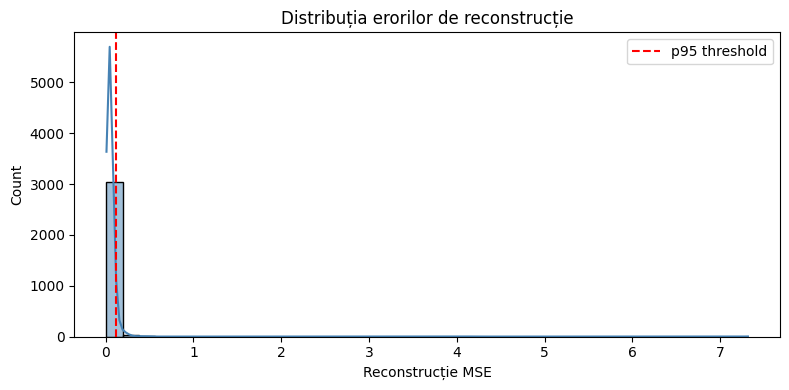

In [203]:
# 7. Histograma erorilor
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(recon_error, bins=40, kde=True, color="steelblue")
plt.axvline(thr, color="red", ls="--", label="p95 threshold")
plt.title("Distribu»õia erorilor de reconstruc»õie")
plt.xlabel("Reconstruc»õie MSE"); plt.legend(); plt.tight_layout(); plt.show()

In [204]:
# 8. Top 10 anomalii
top10 = (pdf.sort_values("recon_error", ascending=False)
           .head(10)[["countries", "year", "recon_error"]])
print(top10.to_string(index=False))

       countries  year  year  recon_error
   United States  2001  2001     7.317027
    Sierra Leone  2000  2000     4.187108
    Sierra Leone  2001  2001     0.529583
        Zimbabwe  2000  2000     0.470760
            Peru  2000  2000     0.444863
          Turkey  2000  2000     0.443478
         Myanmar  2000  2000     0.407409
Congo, Dem. Rep.  2000  2000     0.399754
        Pakistan  2000  2000     0.389105
            Iraq  2020  2020     0.351357


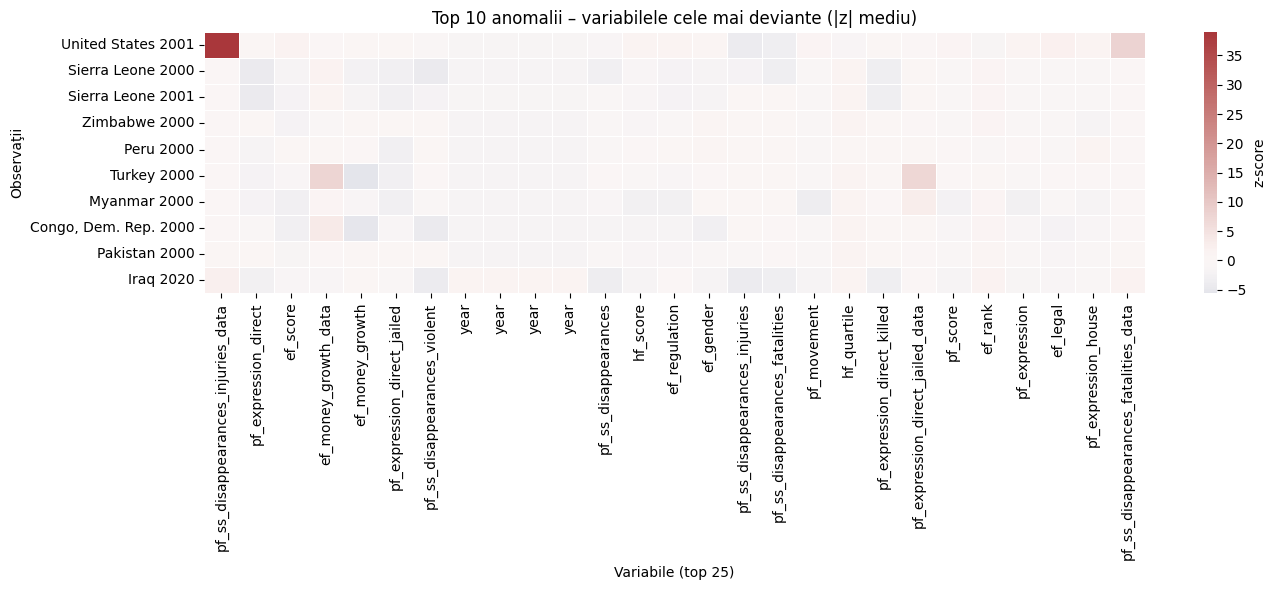

In [ ]:
# 9. HEAT-MAP ‚Äì profilul celor mai mari 10 erori de reconstruc≈£ie
import scipy.stats as st

# (a) cele mai mari 10 erori
top_idx = np.argsort(recon_error)[-10:][::-1]      # descrescƒÉtor

# (b) z-score pe toate variabilele numerice
pdf_z = pd.DataFrame(st.zscore(pdf_num), columns=pdf_num.columns)
heat_data = pdf_z.iloc[top_idx]

# (c) selectƒÉm 25 variabile cu |z| mediu maxim
cols_sel = (heat_data.abs()
                       .mean()
                       .sort_values(ascending=False)
                       .head(25)
                       .index)
heat_data = heat_data[cols_sel]

# ---- etichete UNICE pentru r√¢nduri -------------------------------
labels_raw = []
for i in top_idx:
    country = str(pdf.iloc[i]['countries'])
    year_val = pdf.iloc[i]['year']

    # dacƒÉ, printr-un accident de coloanƒÉ dublatƒÉ, year devine Series:
    if isinstance(year_val, (pd.Series, np.ndarray, list)):
        year_val = year_val.iloc[0] if isinstance(year_val, pd.Series) else year_val[0]

    labels_raw.append(f"{country} {int(year_val)}")

# de-duplicƒÉm dacƒÉ apar etichete identice
labels, seen = [], {}
for lbl in labels_raw:
    if lbl in seen:
        seen[lbl] += 1
        labels.append(f"{lbl}_{seen[lbl]}")    # ex. ‚ÄúChile 2005_2‚Äù
    else:
        seen[lbl] = 0
        labels.append(lbl)

heat_data.index = labels

# (d) desen
plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_data,
    cmap="vlag",
    center=0,
    linewidths=.5,
    cbar_kws=dict(label="z-score")
)
plt.title("Top 10 anomalii ‚Äì variabilele cele mai deviante (|z| mediu)")
plt.xlabel("Variabile (top 25)")
plt.ylabel("Observa≈£ii")
plt.tight_layout()
plt.show()


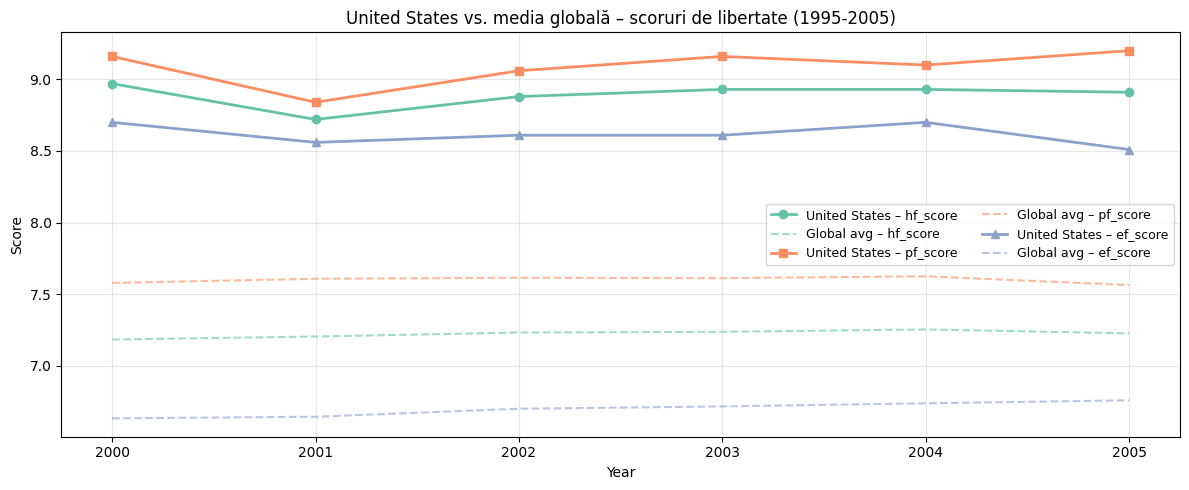

In [ ]:
# 10. √énlƒÉturƒÉm coloanele duplicate (inclusiv dublurile de 'year')
dup_mask = pdf.columns.duplicated()
if dup_mask.any():
    pdf = pdf.loc[:, ~dup_mask]        # pƒÉstrƒÉm doar prima apari»õie

# asigurƒÉm tip numeric pt. year
pdf["year"] = pd.to_numeric(pdf["year"], errors="coerce")

# TIMELINE ‚Äì SUA vs. media globalƒÉ (1995-2005)
cols_focus = ["hf_score", "pf_score", "ef_score"]
country_id = "United States"     # schimbƒÉ aici dacƒÉ e altƒÉ denumire

mask_usa = (
    (pdf["countries"] == country_id) &
    (pdf["year"] >= 1995) &
    (pdf["year"] <= 2005)
)
usa = (pdf.loc[mask_usa, ["year"] + cols_focus]
         .drop_duplicates(subset="year"))

if usa.empty:
    raise ValueError(f"N-am gƒÉsit r√¢nduri pentru ¬´{country_id}¬ª 1995-2005.")

# completƒÉm anii lipsƒÉ (NaN) pentru continuitate pe axa X
all_years = pd.DataFrame({"year": np.arange(1995, 2006)})
usa       = all_years.merge(usa, on="year", how="left")

# media globalƒÉ
mask_world = (pdf["year"] >= 1995) & (pdf["year"] <= 2005)
world_mean = (pdf.loc[mask_world]
                .groupby("year")[cols_focus]
                .mean()
                .reset_index()
                .rename(columns={c: f"mean_{c}" for c in cols_focus}))

timeline = (usa.merge(world_mean, on="year", how="left")
               .sort_values("year")
               .set_index("year"))

# -------------------- plot --------------------
plt.figure(figsize=(12, 5))
marker_map = {"hf_score": "o", "pf_score": "s", "ef_score": "^"}
color_map  = dict(zip(cols_focus, sns.color_palette("Set2", 3)))

for col in cols_focus:
    # SUA
    plt.plot(timeline.index, timeline[col],
             marker=marker_map[col], color=color_map[col],
             linewidth=2, label=f"{country_id} ‚Äì {col}")
    # media globalƒÉ
    plt.plot(timeline.index, timeline[f"mean_{col}"],
             ls="--", color=color_map[col], alpha=.6,
             label=f"Global avg ‚Äì {col}")

plt.title(f"{country_id} vs. media globalƒÉ ‚Äì scoruri de libertate (1995-2005)")
plt.xlabel("Year"); plt.ylabel("Score")
plt.grid(alpha=.3); plt.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()

# 7. Varianta care nu functioneaza si da eroare este mai jos, iar link-ul catre Google Colab-ul unde am reusit sa implementez codul este: https://colab.research.google.com/drive/1YciXXvRfFhmOP5JKKp9btrLCeqKJs5iV#scrollTo=s-y6dBDHw2J9

In [214]:
# ----------------- 0. CONFIGURƒÇRI ENV -----------------
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["HADOOP_HOME"] = r"C:\hadoop"
os.environ["PATH"] += r";C:\hadoop\bin"

In [215]:
# ----------------- 1. IMPORTURI -----------------
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import col
from pyspark.ml.feature import IndexToString
import pandas as pd
import time

In [216]:
if 'spark' in locals():
    spark.stop()

# ----------------- 2. PORNIM SPARK -----------------
spark = SparkSession.builder.appName("FreedomStreamTest").getOrCreate()

In [218]:
# ----------------- 3. √éNCƒÇRCƒÇM MODELUL -----------------
model_path = "models/freedom_classifier_pipeline"
loaded_model = PipelineModel.load(model_path)

Py4JJavaError: An error occurred while calling o24921.text.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:817)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1415)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1620)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:739)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2078)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2122)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:961)
	at org.apache.spark.util.HadoopFSUtils$.listLeafFiles(HadoopFSUtils.scala:218)
	at org.apache.spark.util.HadoopFSUtils$.$anonfun$parallelListLeafFilesInternal$1(HadoopFSUtils.scala:132)
	at scala.collection.immutable.List.map(List.scala:247)
	at scala.collection.immutable.List.map(List.scala:79)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFilesInternal(HadoopFSUtils.scala:122)
	at org.apache.spark.util.HadoopFSUtils$.parallelListLeafFiles(HadoopFSUtils.scala:72)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex$.bulkListLeafFiles(InMemoryFileIndex.scala:178)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.listLeafFiles(InMemoryFileIndex.scala:134)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.refresh0(InMemoryFileIndex.scala:98)
	at org.apache.spark.sql.execution.datasources.InMemoryFileIndex.<init>(InMemoryFileIndex.scala:70)
	at org.apache.spark.sql.execution.datasources.DataSource.createInMemoryFileIndex(DataSource.scala:563)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:420)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:290)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:286)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:286)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:249)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:280)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:280)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:121)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$1(Dataset.scala:115)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:113)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:109)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:58)
	at org.apache.spark.sql.DataFrameReader.text(DataFrameReader.scala:535)
	at org.apache.spark.sql.classic.DataFrameReader.text(DataFrameReader.scala:329)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)


In [219]:
# ----------------- 4. FI»òIERE DE INTRARE -----------------
input_dir = "stream_input"
os.makedirs(input_dir, exist_ok=True)
processed = set()

In [220]:
# ----------------- 5. LOOP SIMPLU DE STREAMING -----------------
print("Streaming activ. CopiazƒÉ fi»ôiere CSV √Æn 'stream_input/'...")

start = time.time()
timeout = 60  # ruleazƒÉ 1 minut

while time.time() - start < timeout:
    for file in os.listdir(input_dir):
        if file.endswith(".csv") and file not in processed:
            try:
                print(f"\nFi»ôier detectat: {file}")
                df = pd.read_csv(os.path.join(input_dir, file)).dropna()
                sdf = spark.createDataFrame(df)
                sdf = sdf.withColumn("year", col("year").cast("int"))
                result = loaded_model.transform(sdf)

                # Convertim predic»õia √Æn label (Low/Medium/High)
                decoder = IndexToString(
                    inputCol="prediction",
                    outputCol="predicted_category",
                    labels=["Low", "Medium", "High"]
                )
                final = decoder.transform(result)

                # Print stabil, fƒÉrƒÉ .show()!
                for row in final.select("countries", "region", "predicted_category").collect():
                    print(f"{row['countries']} ({row['region']}): {row['predicted_category']}")

                processed.add(file)

            except Exception as e:
                print(f"Eroare la {file}: {e}")

    time.sleep(5)

print("\nStreaming finalizat.")

Streaming activ. CopiazƒÉ fi»ôiere CSV √Æn 'stream_input/'...

Fi»ôier detectat: input_auto_1.csv
Eroare la input_auto_1.csv: name 'loaded_model' is not defined

Fi»ôier detectat: input_auto_2.csv
Eroare la input_auto_2.csv: name 'loaded_model' is not defined

Fi»ôier detectat: input_auto_3.csv
Eroare la input_auto_3.csv: name 'loaded_model' is not defined


KeyboardInterrupt: 